In [6]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import sys
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import os
import json
from analysis_tools import WaveformProcessingmPMT
from analysis_tools.pulse_finding import do_pulse_finding_vect
import time

In [2]:
def match_hits_waveforms(event):
    #this function acts on one readout window (or event) to match the hits and waveform indices
    
    hit_times  = event["hit_pmt_times"]
    hit_cards  = event["hit_mpmt_card_ids"]
    hit_chan   = event["hit_pmt_channel_ids"]

    wf_start   = event["pmt_waveform_times"]
    wf_wave    = event["pmt_waveforms"]
    wf_end     = wf_start + 8.0 * ak.num(wf_wave)
    wf_card    = event["pmt_waveform_mpmt_card_ids"]
    wf_chan    = event["pmt_waveform_pmt_channel_ids"]

    # ----------------------------------------
    # Vectorized matching
    # ----------------------------------------

    # Broadcast hits vs waveforms
    card_match = hit_cards == wf_card[:, None]
    chan_match = hit_chan == wf_chan[:, None]
    time_match = (hit_times > wf_start[:, None]) & (hit_times < wf_end[:, None])

    match_matrix = card_match & chan_match & time_match  # (wf, hits)
    ##2d array of true and false for matches of each hit to each waveform

    # ----------------------------------------
    # For each hit → find waveform
    # ----------------------------------------
    hit_nmatch = ak.sum(match_matrix, axis=0)
    hit_match_index = ak.where(hit_nmatch>0, ak.argmax(match_matrix, axis=0),-1) 

    # if hit_nmatch==0:
    #     hit_match_index = -1
    # else:
    #     hit_match_index = ak.argmax(match_matrix, axis=0)     # first True or 0

    # Hits with no waveform
    hits_no_wf = hit_times[hit_nmatch == 0]
    
    # ----------------------------------------
    # For each waveform → find hit
    # ----------------------------------------
    wf_nmatch = ak.sum(match_matrix, axis=1)
    wf_match_index = ak.where(wf_nmatch>0, ak.argmax(match_matrix, axis=1),-1) 
    
    # if wf_nmatch==0:
    #     wf_match_index = -1
    # else:
    #     wf_match_index = ak.argmax(match_matrix, axis=1)   # first True or 0
    
    return hit_match_index, wf_match_index 
    

In [7]:
runNumber = 1703
file_path = "/eos/experiment/wcte/data/2025_commissioning/offline_data_vme_match/WCTE_offline_R"+str(runNumber)+"S0_VME_matched.root"

with uproot.open(file_path) as root_file:
    tree = root_file["WCTEReadoutWindows"]
    all_events = tree.arrays(library="ak", entry_start=0, entry_stop=100)


In [8]:
def do_hit_processing(waveforms, waveform_times, waveform_cards, waveform_channels):
    
    #run on self-trigger data 
    
    verbose = False
    
    wf_numpy = ak.to_numpy(waveforms)
    wf_length = 32
    
    # ============================================================
    # SECTION 1) do the pulse finding
    # ============================================================
    start_time = time.time()
    hit_indices = do_pulse_finding_vect(wf_numpy) ##indices of the pulse in each waveform
    hit_indices = ak.Array(hit_indices)
    end_time = time.time()
    if verbose: print(f"Pulse finding took {end_time - start_time:.6f} seconds")

    # ============================================================
    # SECTION 2) now want to make an array of waveforms corresponding 
    #    to each hit with the info needed for CFD and charge calculation
    # ============================================================
    #get the index of the waveform in each case that corresponds to the hit and flatten
    row_wf_index = ak.local_index(hit_indices, axis=0) #returns the index of outer most array - the dimension of wfs
    # essentially[ wf_0, wf_1 wf_2 ...] since this is what was fed into the do_pulse_finding_vect
    hit_wf_index, _ = ak.broadcast_arrays(row_wf_index[:, None], hit_indices)
    # now using broadcast_arrays we broadcast that shape onto hit_indices to produce an array like [[wf_1,wf_1],[wf_2],..] with n hits as second dimension
    #now we flatten
    hit_wf_index = ak.flatten(hit_wf_index) # index of the waveform for each hit
    hit_indices_flat = ak.to_numpy(ak.flatten(hit_indices)) # list of where the hits are in the waveform - flat one for each hit

    #make a full array of the waveforms for each flat hit for later 
    each_hit_waveform = wf_numpy[hit_wf_index] #length of n hits the corresponding full waveform
    
    #slice up the big waveform array into samples we are interested in
    #for each hit where do we want to start the sample in the waveform
    slice_len = 12
    peak_position = 8
    local_idx = np.arange(slice_len)
    start_sample = hit_indices_flat-peak_position
    
    #this makes a 2d array using broadcasting which sample to pick for each element 
    slice_idx = start_sample[:, None] + local_idx[None, :]  # shape (num_hits, slice_len)

    ## hit_idx is shape (n_hits, 1) slice_idx is shape (num_hits, slice_len), they are broadcasted to (num_hits, slice_len)
    # waveform_samples will be shape (num_hits, slice_len) each element waveform_samples[i, j] is each_hit_waveform[hit_idx[i, j],slice_idx[i,j]]
    hit_idx = np.arange(len(hit_indices_flat))[:, None]
    waveform_samples = each_hit_waveform[hit_idx, slice_idx]

    # ============================================================
    # SECTION 3) Now do the charge and time calculations
    # ============================================================
    offlineProcessing = WaveformProcessingmPMT()
    start_time = time.time()
    _,cfd_time_vector_corr,_,_ = offlineProcessing.cfd_vectorized(waveform_samples)
    found_cfd_time = start_sample + cfd_time_vector_corr #relative to start of the waveform
    found_hit_time = waveform_times[hit_wf_index] + (found_cfd_time*8.0) #relative to start of the window
    end_time = time.time()
    if verbose: print(f"Function vectorised took {end_time - start_time:.6f} seconds")

    found_hit_charge = offlineProcessing.charge_vectorized_mPMT_method(waveform_samples,peak_position)
    
    found_hit_card = waveform_cards[hit_wf_index]
    found_hit_chan = waveform_channels[hit_wf_index]

    return found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_indices_flat 

    
    

Check should be the same length 904 904
----- Found lack of match -7.626927453182475
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 138.0 138.0
Compare time offline online 7389.296225882353 7450.3116455078125


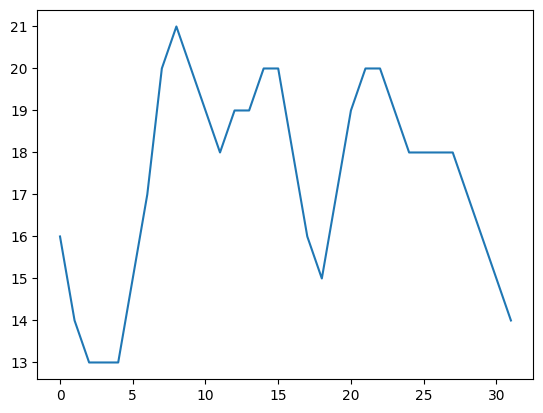

############ Finished procressing event 0 checked 904 waveforms with 1 problems
Check should be the same length 871 871
----- Found lack of match -3.629374006606213
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 267.0 267.0
Compare time offline online 2241.5492364627753 2270.584228515625


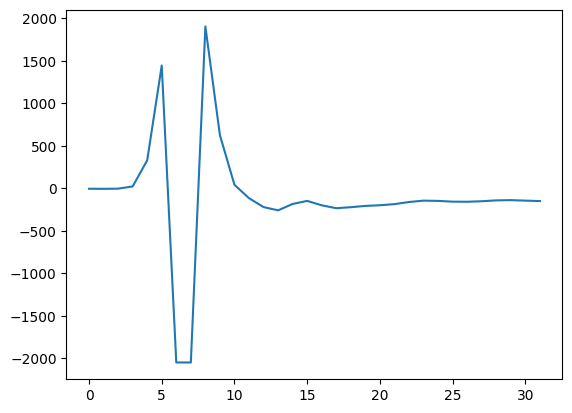

############ Finished procressing event 1 checked 869 waveforms with 1 problems
Check should be the same length 1564 1564
----- Found lack of match -2.6308302756038984
hit local index  8
Compare card offline online 30 30
Compare chan offline online 13 13
Compare charge offline online 902.0 902.0
Compare time offline online 1281.6413460764188 1302.68798828125


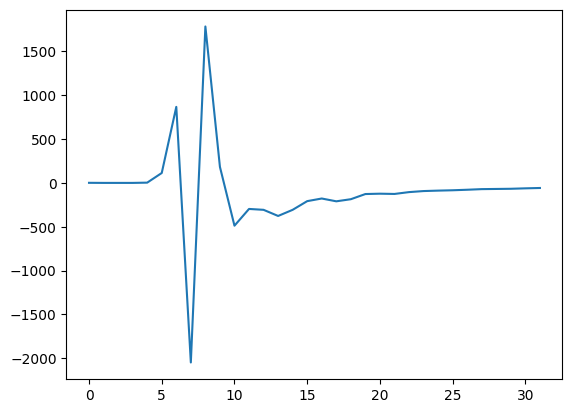

----- Found lack of match -2.629727107087504
hit local index  8
Compare card offline online 48 48
Compare chan offline online 1 1
Compare charge offline online 994.0 994.0
Compare time offline online 945.6510259167375 966.6888427734375


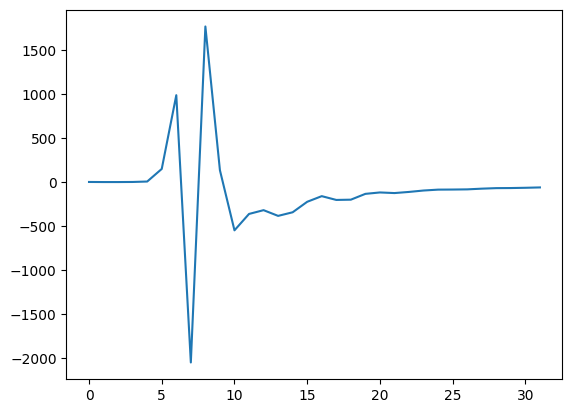

----- Found lack of match -2.633172149435836
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1611.0 1611.0
Compare time offline online 6505.532034913888 6526.597412109375


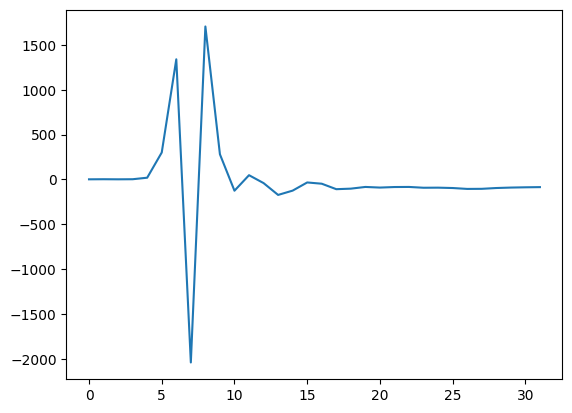

############ Finished procressing event 2 checked 1563 waveforms with 3 problems
Check should be the same length 860 860
No hit match for waveform at  7944.0
----- Found lack of match -2.7217218938847623
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 2447.0 2447.0
Compare time offline online 1944.802640864547 1966.576416015625


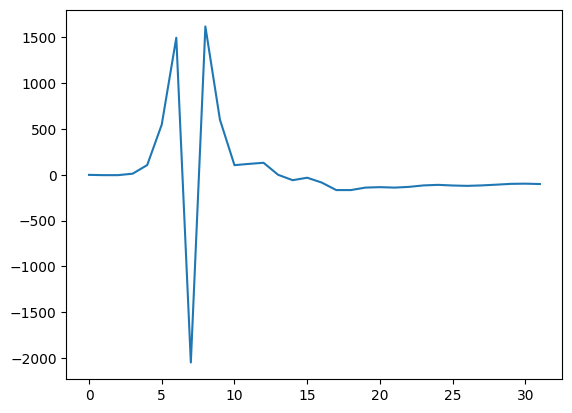

############ Finished procressing event 3 checked 858 waveforms with 1 problems
Check should be the same length 378 378
No hit match for waveform at  7968.0
############ Finished procressing event 4 checked 376 waveforms with 0 problems
Check should be the same length 924 924
No hit match for waveform at  7968.0
############ Finished procressing event 5 checked 921 waveforms with 0 problems
Check should be the same length 796 796
----- Found lack of match -8.225215263129371
hit local index  8
Compare card offline online 132 132
Compare chan offline online 1 1
Compare charge offline online 151.0 151.0
Compare time offline online 5861.3126577777775 5927.1143798828125


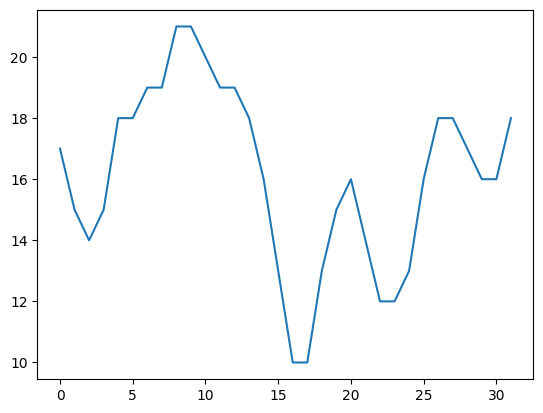

----- Found lack of match -0.6047573308749747
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2025.0 2025.0
Compare time offline online 2209.2582548295627 2214.0963134765625


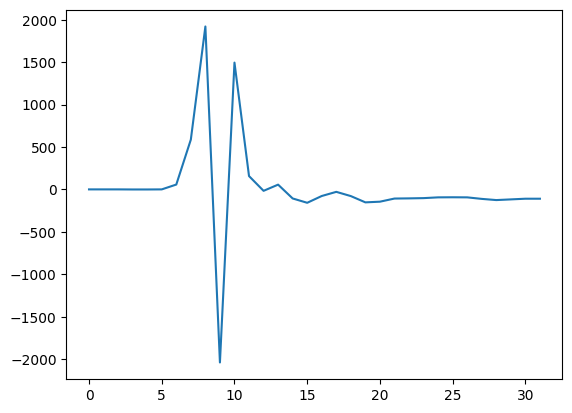

----- Found lack of match -3.658536210688908
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 1011.0 1011.0
Compare time offline online 2241.4134730098012 2270.6817626953125


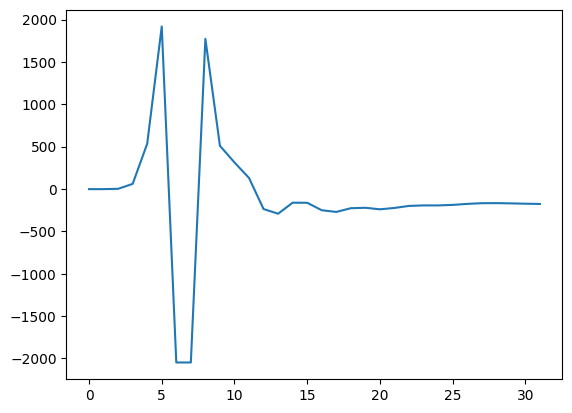

----- Found lack of match -3.619567193445107
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 146.0 146.0
Compare time offline online 2241.300542530564 2270.257080078125


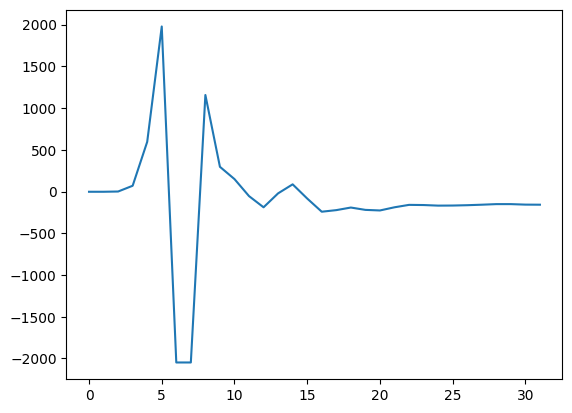

############ Finished procressing event 6 checked 794 waveforms with 4 problems
Check should be the same length 722 722
----- Found lack of match -7.794184003906253
hit local index  8
Compare card offline online 109 109
Compare chan offline online 3 3
Compare charge offline online 167.0 167.0
Compare time offline online 973.54936 1035.90283203125


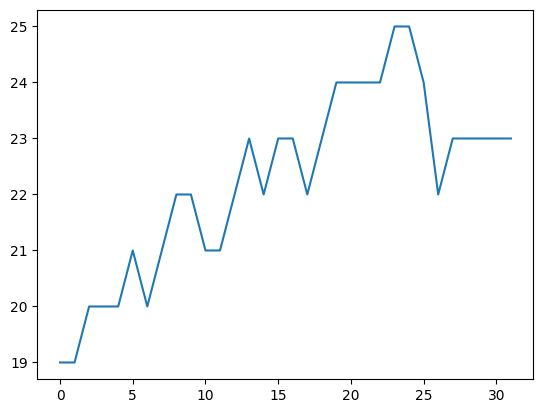

----- Found lack of match -0.644218105031598
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1590.0 1590.0
Compare time offline online 2209.230776644122 2214.384521484375


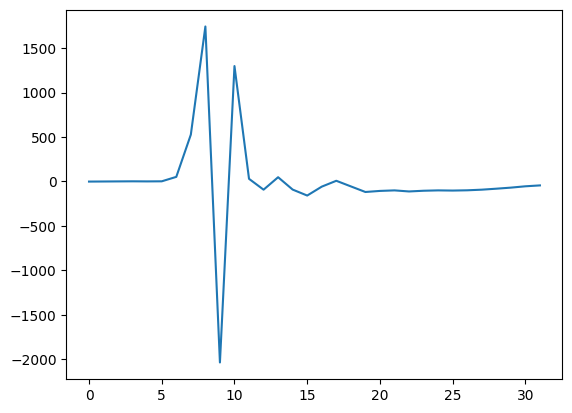

----- Found lack of match -0.6447759922001524
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1430.0 1430.0
Compare time offline online 2209.218256906149 2214.37646484375


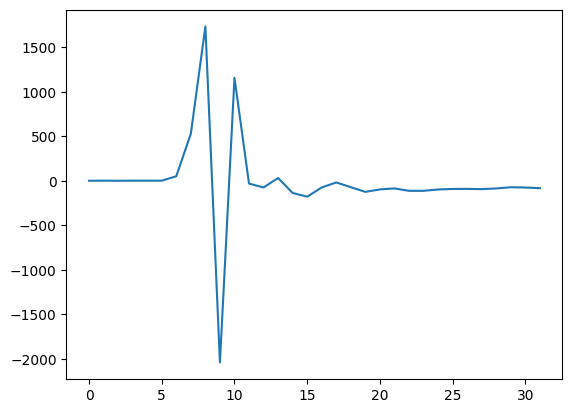

############ Finished procressing event 7 checked 719 waveforms with 3 problems
Check should be the same length 894 894
############ Finished procressing event 8 checked 891 waveforms with 0 problems
Check should be the same length 143 143
----- Found lack of match -2.645734306950601
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1245.0 1245.0
Compare time offline online 2209.5017280834577 2230.6676025390625


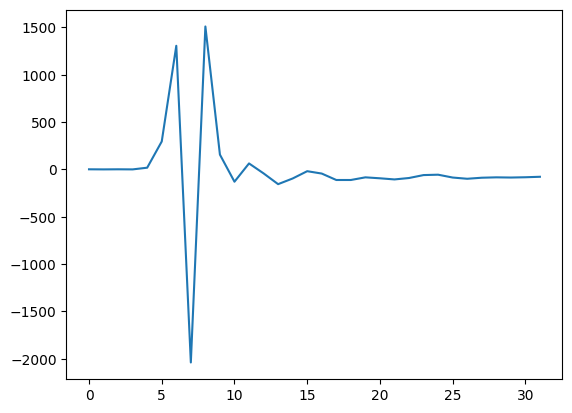

----- Found lack of match -2.6827036123950165
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 1837.0 1837.0
Compare time offline online 2241.1822919992774 2262.6439208984375


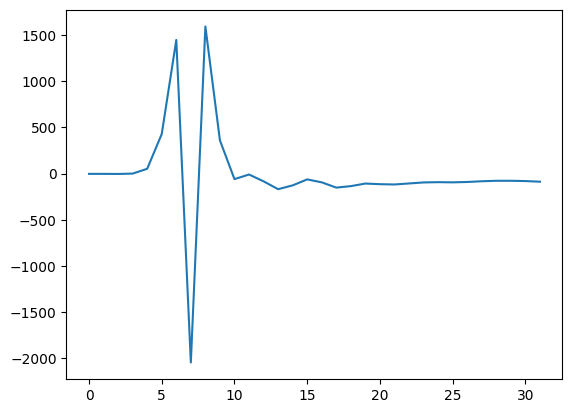

############ Finished procressing event 9 checked 143 waveforms with 2 problems
Check should be the same length 126 126
############ Finished procressing event 10 checked 126 waveforms with 0 problems
Check should be the same length 342 342
############ Finished procressing event 11 checked 342 waveforms with 0 problems
Check should be the same length 673 673
----- Found lack of match -7.2932994871795245
hit local index  8
Compare card offline online 132 132
Compare chan offline online 7 7
Compare charge offline online 169.0 169.0
Compare time offline online 6693.653604102564 6752.0


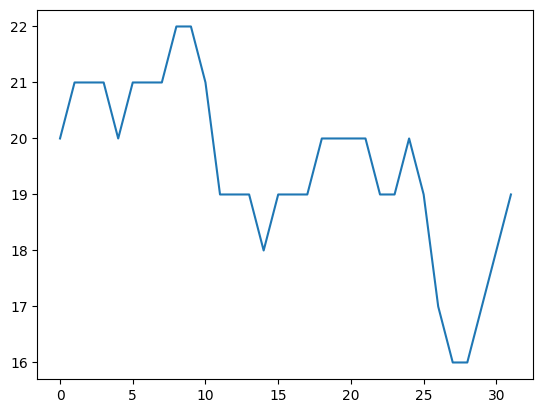

----- Found lack of match -7.294492093023223
hit local index  8
Compare card offline online 132 132
Compare chan offline online 7 7
Compare charge offline online 159.0 159.0
Compare time offline online 7413.644063255814 7472.0


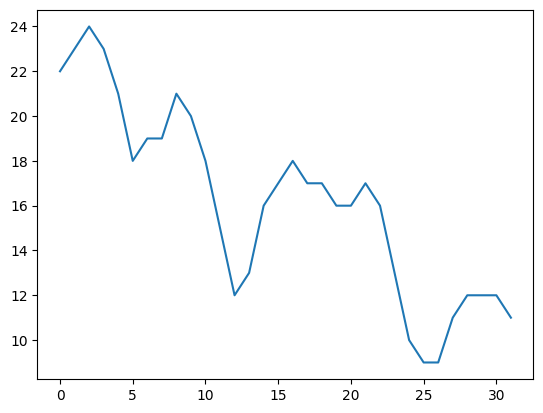

############ Finished procressing event 12 checked 671 waveforms with 2 problems
Check should be the same length 104 104
############ Finished procressing event 13 checked 104 waveforms with 0 problems
Check should be the same length 667 667
############ Finished procressing event 14 checked 667 waveforms with 0 problems
Check should be the same length 780 780
############ Finished procressing event 15 checked 778 waveforms with 0 problems
Check should be the same length 870 870
############ Finished procressing event 16 checked 870 waveforms with 0 problems
Check should be the same length 885 885
----- Found lack of match -2.6479991205307556
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1289.0 1289.0
Compare time offline online 2209.416348832629 2230.600341796875


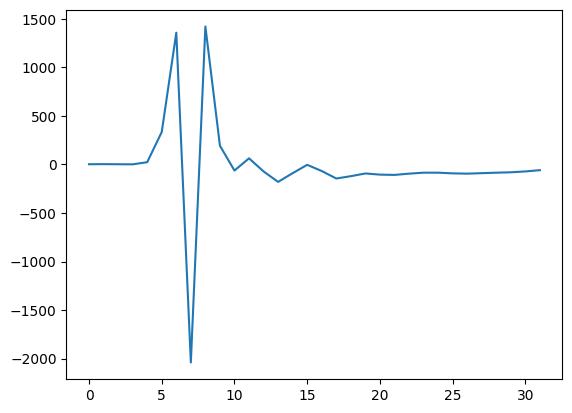

----- Found lack of match -2.6706087528439184
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 2518.0 2518.0
Compare time offline online 2241.323972750686 2262.6888427734375


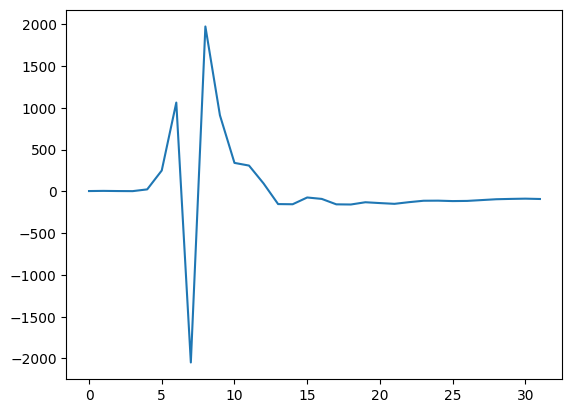

############ Finished procressing event 17 checked 884 waveforms with 2 problems
Check should be the same length 926 926
----- Found lack of match -0.6069992358770264
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1869.0 1869.0
Compare time offline online 2209.2989133395463 2214.1549072265625


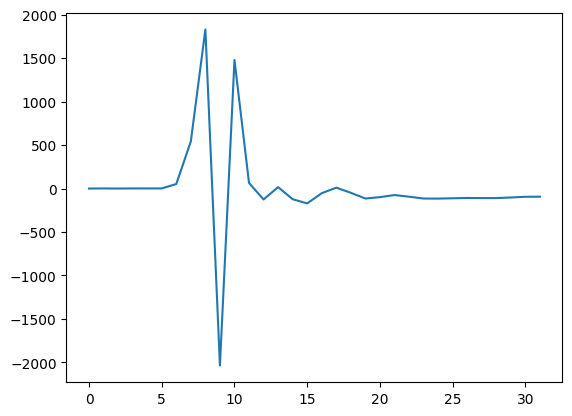

----- Found lack of match -3.912859333879453
hit local index  8
Compare card offline online 130 130
Compare chan offline online 16 16
Compare charge offline online 185.0 185.0
Compare time offline online 2499.395489586777 2530.6983642578125


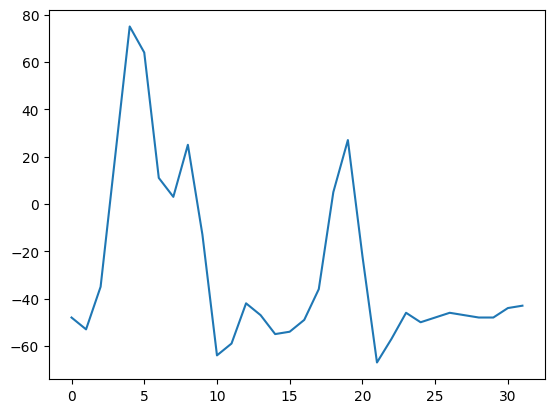

############ Finished procressing event 18 checked 926 waveforms with 2 problems
Check should be the same length 893 893
############ Finished procressing event 19 checked 893 waveforms with 0 problems
Check should be the same length 205 205
----- Found lack of match -0.5870058340033779
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2229.0 2229.0
Compare time offline online 2209.366941609223 2214.06298828125


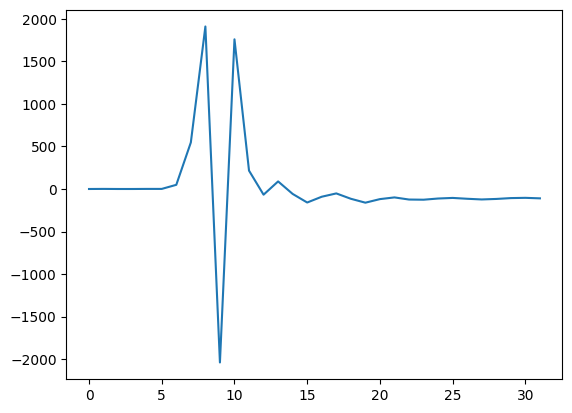

############ Finished procressing event 20 checked 204 waveforms with 1 problems
Check should be the same length 747 747
############ Finished procressing event 21 checked 747 waveforms with 0 problems
Check should be the same length 1190 1190
No hit match for waveform at  7984.0
----- Found lack of match -0.6330519210137595
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1804.0 1804.0
Compare time offline online 2209.3441539678274 2214.4085693359375


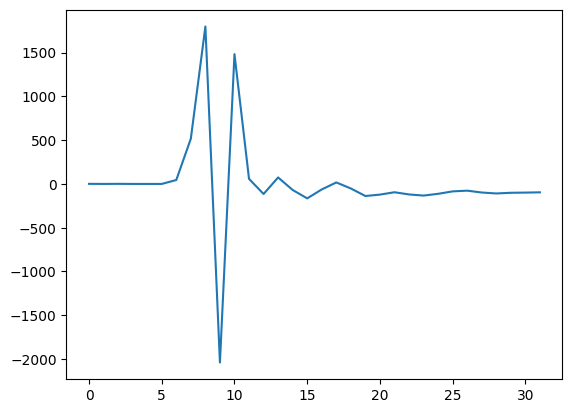

############ Finished procressing event 22 checked 1189 waveforms with 1 problems
Check should be the same length 285 285
############ Finished procressing event 23 checked 284 waveforms with 0 problems
Check should be the same length 854 854
############ Finished procressing event 24 checked 854 waveforms with 0 problems
Check should be the same length 28 28
No hit match for waveform at  7952.0
############ Finished procressing event 25 checked 28 waveforms with 0 problems
Check should be the same length 368 368
----- Found lack of match -0.6216422258430043
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1629.0 1629.0
Compare time offline online 2209.0721502791935 2214.0452880859375


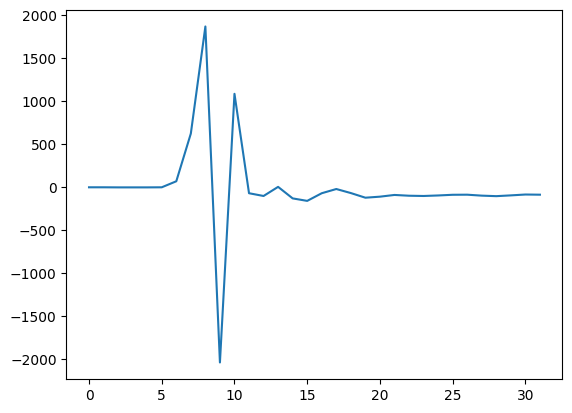

----- Found lack of match -0.6511025046910959
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1793.0 1793.0
Compare time offline online 2209.0222590640337 2214.2310791015625


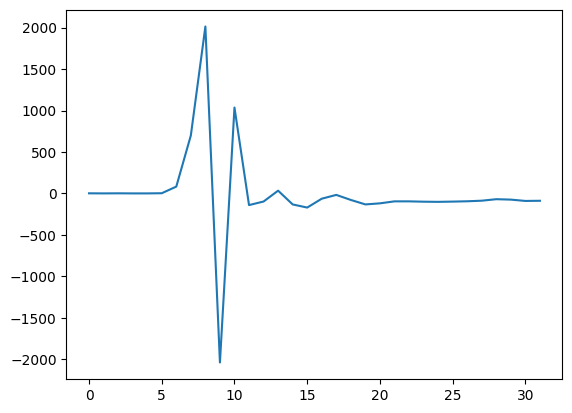

############ Finished procressing event 26 checked 368 waveforms with 2 problems
Check should be the same length 474 474
----- Found lack of match -0.6047011616648774
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1710.0 1710.0
Compare time offline online 2209.3690557457435 2214.2066650390625


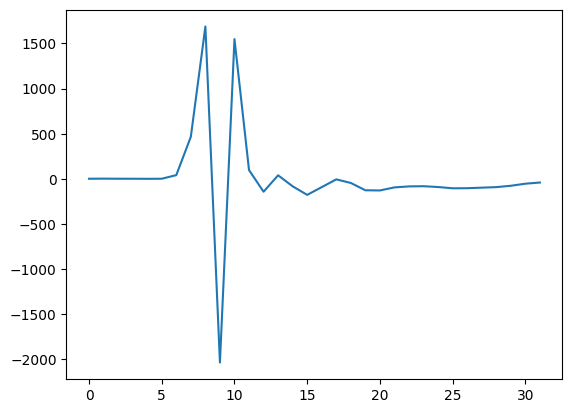

----- Found lack of match -0.6287240512016297
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1797.0 1797.0
Compare time offline online 2209.3194507544495 2214.3492431640625


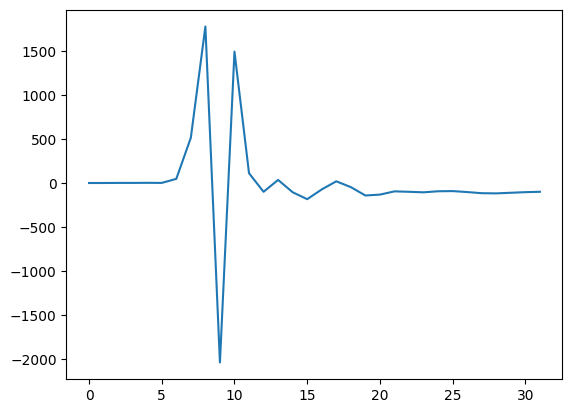

############ Finished procressing event 27 checked 470 waveforms with 2 problems
Check should be the same length 1132 1132
----- Found lack of match -2.643006265062354
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2241.0 2241.0
Compare time offline online 2209.5435719498137 2230.6876220703125


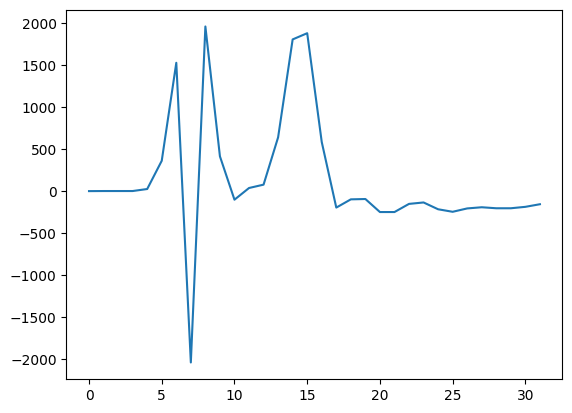

############ Finished procressing event 28 checked 1132 waveforms with 1 problems
Check should be the same length 890 890
----- Found lack of match -0.651342930844919
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1200.0 1200.0
Compare time offline online 2209.2587389751156 2214.469482421875


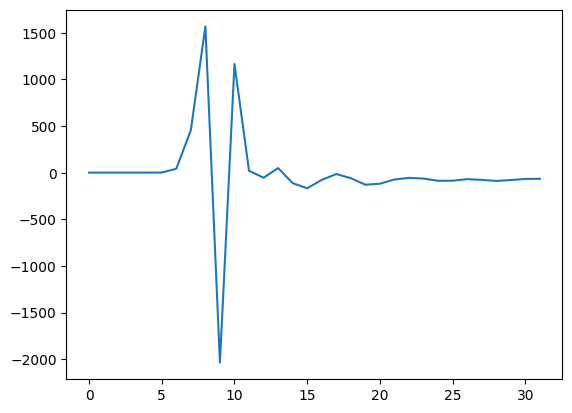

----- Found lack of match -2.6497452579518495
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 2305.0 2305.0
Compare time offline online 2241.111119967635 2262.30908203125


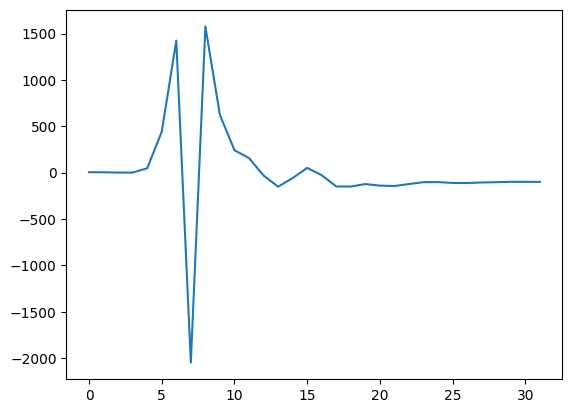

############ Finished procressing event 29 checked 890 waveforms with 2 problems
Check should be the same length 613 613
############ Finished procressing event 30 checked 612 waveforms with 0 problems
Check should be the same length 798 798
----- Found lack of match -2.670516371534177
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 1425.0 1425.0
Compare time offline online 4201.323857308977 4222.68798828125


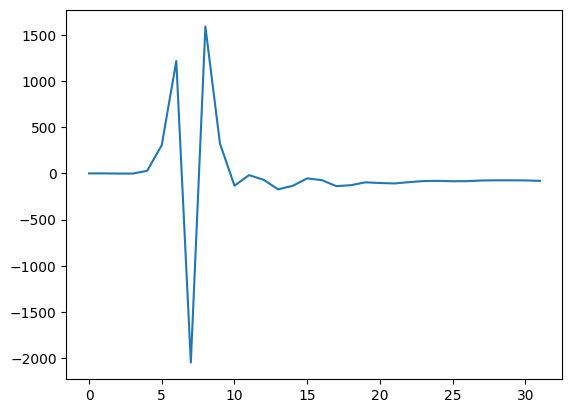

############ Finished procressing event 31 checked 797 waveforms with 1 problems
Check should be the same length 931 931
############ Finished procressing event 32 checked 931 waveforms with 0 problems
Check should be the same length 929 929
############ Finished procressing event 33 checked 929 waveforms with 0 problems
Check should be the same length 372 372
############ Finished procressing event 34 checked 372 waveforms with 0 problems
Check should be the same length 903 903
############ Finished procressing event 35 checked 902 waveforms with 0 problems
Check should be the same length 801 801
############ Finished procressing event 36 checked 800 waveforms with 0 problems
Check should be the same length 859 859
----- Found lack of match -7.286129999999957
hit local index  8
Compare card offline online 132 132
Compare chan offline online 2 2
Compare charge offline online 135.0 135.0
Compare time offline online 7621.71096 7680.0


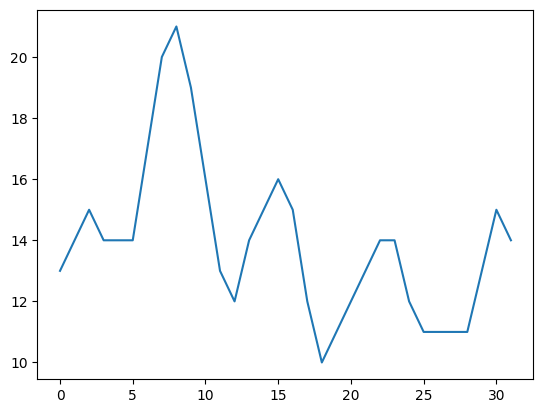

----- Found lack of match -2.6446431044690257
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1269.0 1269.0
Compare time offline online 2209.443196961123 2230.600341796875


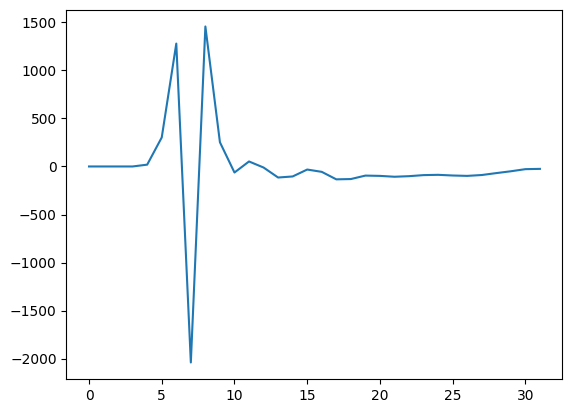

----- Found lack of match -3.669008567856224
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 1127.0 1127.0
Compare time offline online 2241.3218816524627 2270.6739501953125


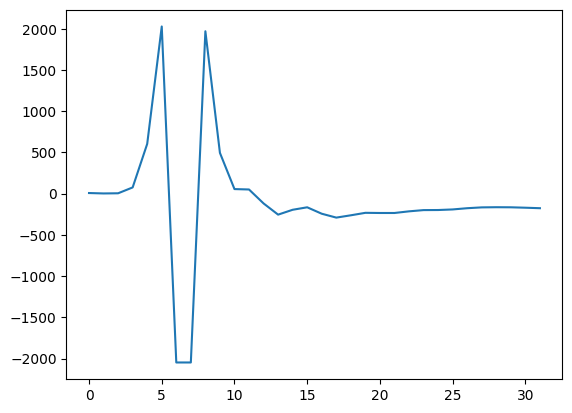

############ Finished procressing event 37 checked 857 waveforms with 3 problems
Check should be the same length 950 950
No hit match for waveform at  7944.0
No hit match for waveform at  7952.0
No hit match for waveform at  7952.0
No hit match for waveform at  7952.0
No hit match for waveform at  7960.0
----- Found lack of match -2.6907195210587247
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 3404.0 3404.0
Compare time offline online 2241.1389166830927 2262.6646728515625


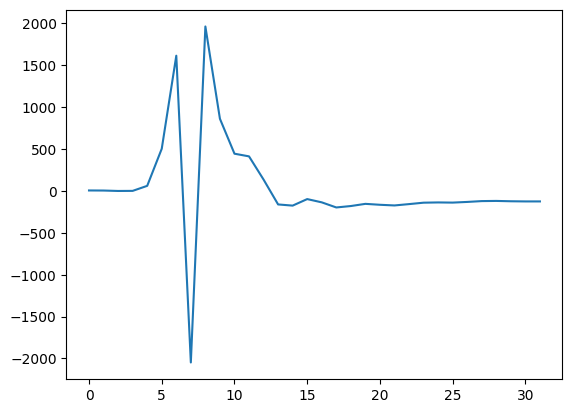

No hit match for waveform at  7976.0
############ Finished procressing event 38 checked 948 waveforms with 1 problems
Check should be the same length 377 377
############ Finished procressing event 39 checked 377 waveforms with 0 problems
Check should be the same length 754 754
----- Found lack of match -7.672067915039065
hit local index  8
Compare card offline online 132 132
Compare chan offline online 16 16
Compare charge offline online 261.0 261.0
Compare time offline online 6589.54936 6650.9259033203125


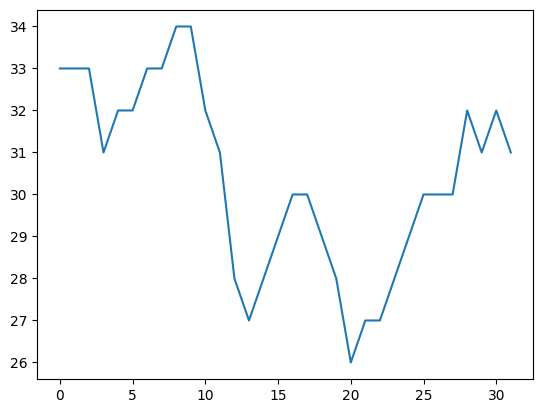

----- Found lack of match -7.88401249511719
hit local index  8
Compare card offline online 132 132
Compare chan offline online 7 7
Compare charge offline online 189.0 189.0
Compare time offline online 7141.54936 7204.6214599609375


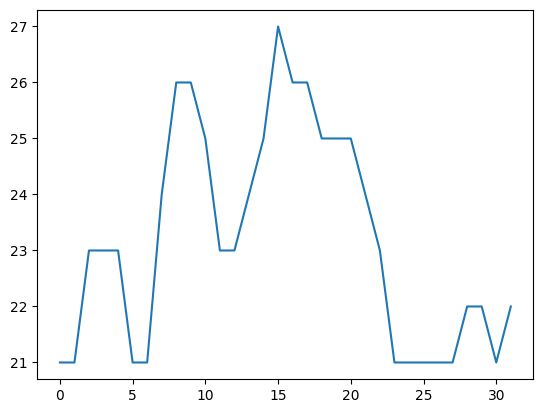

----- Found lack of match -0.6812665498337083
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1268.0 1268.0
Compare time offline online 2209.2183246325803 2214.66845703125


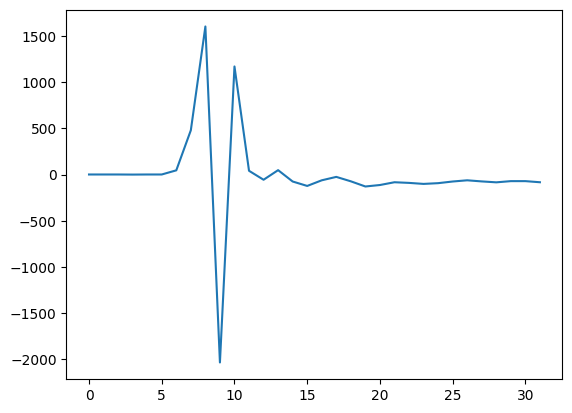

############ Finished procressing event 40 checked 747 waveforms with 3 problems
Check should be the same length 592 592
----- Found lack of match -2.650028693421575
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1245.0 1245.0
Compare time offline online 2209.48934564794 2230.6895751953125


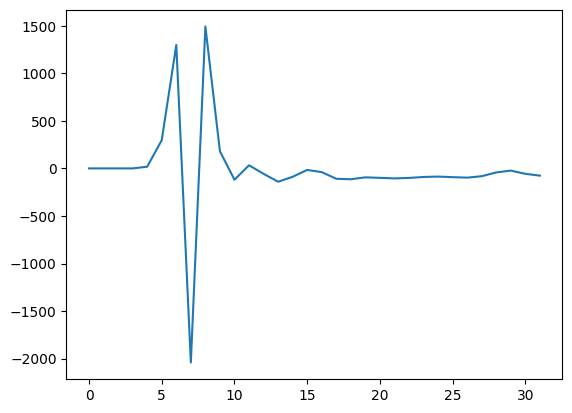

----- Found lack of match -2.659760024482523
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 2464.0 2464.0
Compare time offline online 2241.3196981244523 2262.5977783203125


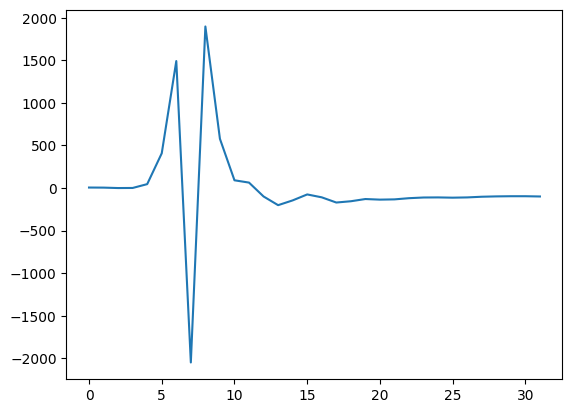

############ Finished procressing event 41 checked 592 waveforms with 2 problems
Check should be the same length 662 662
----- Found lack of match -0.6294349912640769
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1660.0 1660.0
Compare time offline online 2209.18388042145 2214.2193603515625


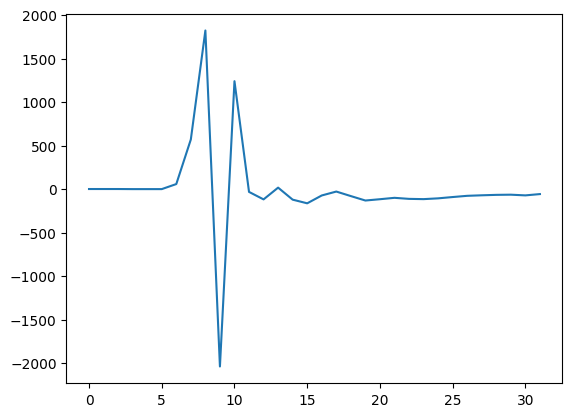

----- Found lack of match -0.6522977282303941
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1388.0 1388.0
Compare time offline online 2209.1184101663443 2214.3367919921875


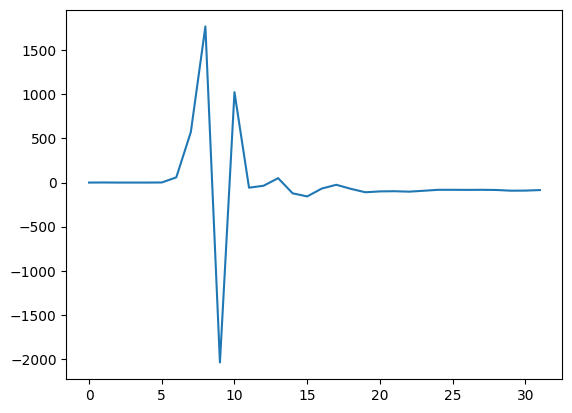

############ Finished procressing event 42 checked 660 waveforms with 2 problems
Check should be the same length 1535 1535
No hit match for waveform at  7960.0
############ Finished procressing event 43 checked 1531 waveforms with 0 problems
Check should be the same length 593 593
----- Found lack of match -7.708972056609127
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 158.0 158.0
Compare time offline online 6485.6801522580645 6547.3519287109375


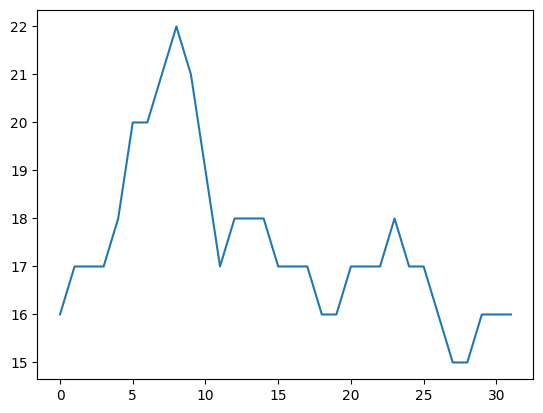

No hit match for waveform at  7984.0
############ Finished procressing event 44 checked 591 waveforms with 1 problems
Check should be the same length 1750 1750
----- Found lack of match -2.6953236555557396
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 2430.0 2430.0
Compare time offline online 2241.126863880554 2262.689453125


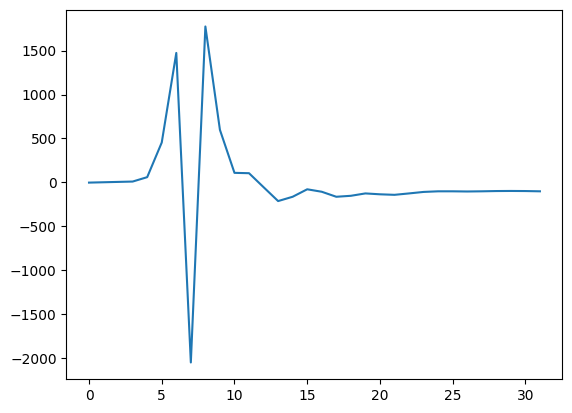

----- Found lack of match -3.3512208889935096
hit local index  8
Compare card offline online 130 130
Compare chan offline online 14 14
Compare charge offline online 133.0 133.0
Compare time offline online 3092.3238998802394 3119.1336669921875


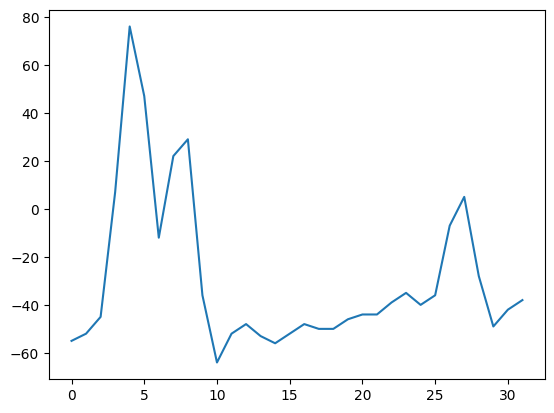

############ Finished procressing event 45 checked 1750 waveforms with 2 problems
Check should be the same length 1011 1011
----- Found lack of match -3.6532485609120045
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 56.0 56.0
Compare time offline online 2241.3713015517665 2270.5972900390625


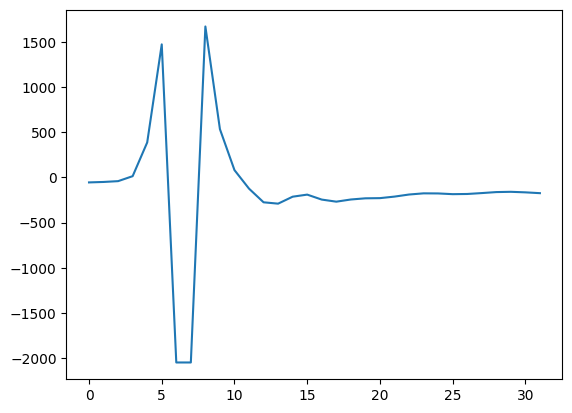

############ Finished procressing event 46 checked 1010 waveforms with 1 problems
Check should be the same length 1272 1272
----- Found lack of match -7.672067915039065
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 162.0 162.0
Compare time offline online 7141.54936 7202.9259033203125


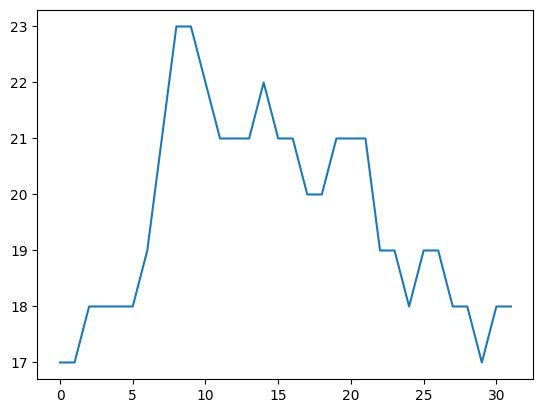

----- Found lack of match 0.0015423690480815822
hit local index  8
Compare card offline online 117 117
Compare chan offline online 19 19
Compare charge offline online 1476.0 1476.0
Compare time offline online 1700.0081885617597 1699.995849609375


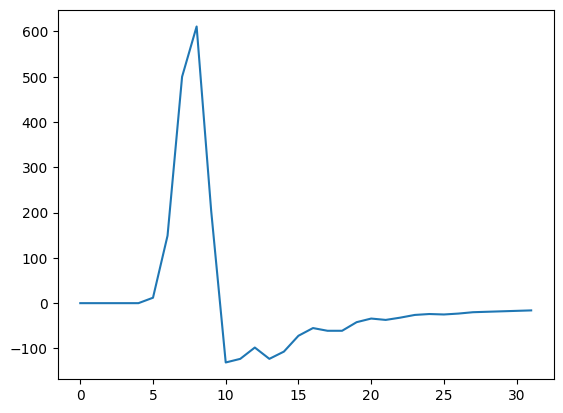

############ Finished procressing event 47 checked 1270 waveforms with 2 problems
Check should be the same length 1011 1011
----- Found lack of match -7.290958484848488
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 152.0 152.0
Compare time offline online 6373.672332121212 6432.0


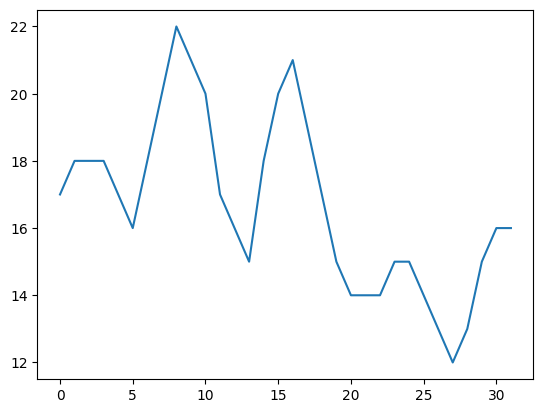

----- Found lack of match -2.631673962654361
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1215.0 1215.0
Compare time offline online 2201.54646181439 2222.599853515625


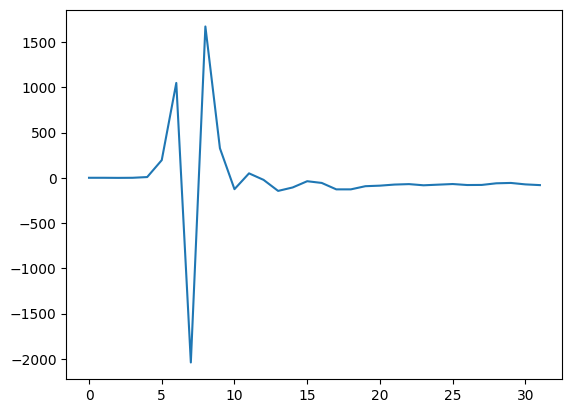

############ Finished procressing event 48 checked 1011 waveforms with 2 problems
Check should be the same length 118 118
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
############ Finished procressing event 49 checked 118 waveforms with 0 problems
Check should be the same length 311 311
----- Found lack of match -2.646130578919724
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1540.0 1540.0
Compare time offline online 2209.496970993642 2230.666015625


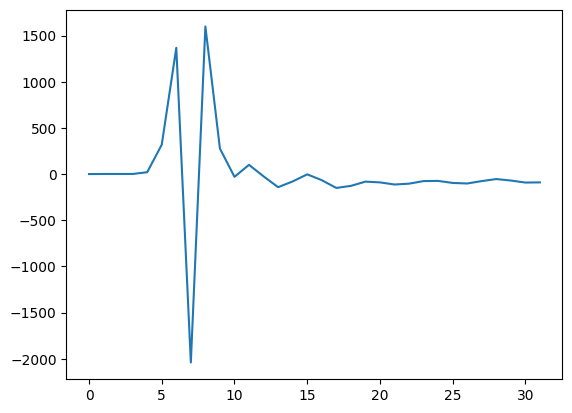

############ Finished procressing event 50 checked 311 waveforms with 1 problems
Check should be the same length 997 997
----- Found lack of match -8.162584152018212
hit local index  8
Compare card offline online 132 132
Compare chan offline online 6 6
Compare charge offline online 135.0 135.0
Compare time offline online 5349.813706666667 5415.1143798828125


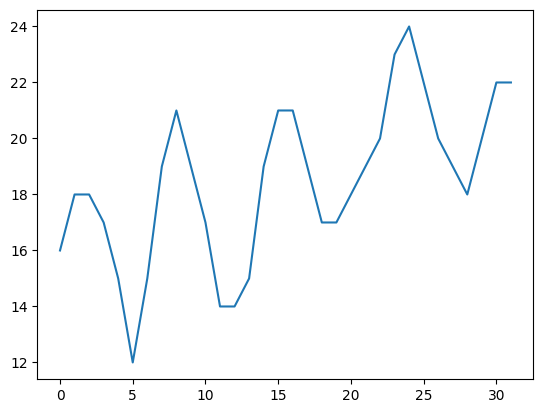

----- Found lack of match -8.195627485351565
hit local index  8
Compare card offline online 132 132
Compare chan offline online 6 6
Compare charge offline online 184.0 184.0
Compare time offline online 5645.54936 5711.1143798828125


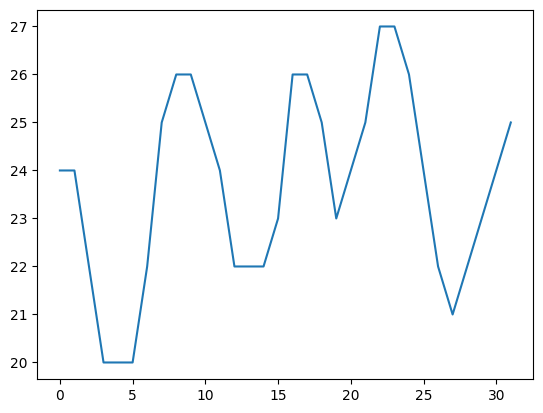

----- Found lack of match -8.195627485351565
hit local index  8
Compare card offline online 132 132
Compare chan offline online 6 6
Compare charge offline online 165.0 165.0
Compare time offline online 7629.54936 7695.1143798828125


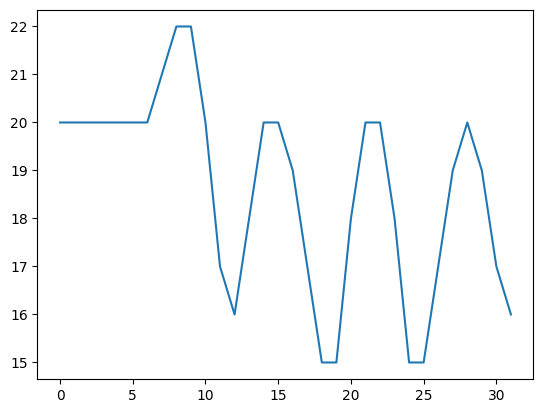

############ Finished procressing event 51 checked 991 waveforms with 3 problems
Check should be the same length 911 911
----- Found lack of match -0.6474401554332871
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1433.0 1433.0
Compare time offline online 2209.2067092252837 2214.38623046875


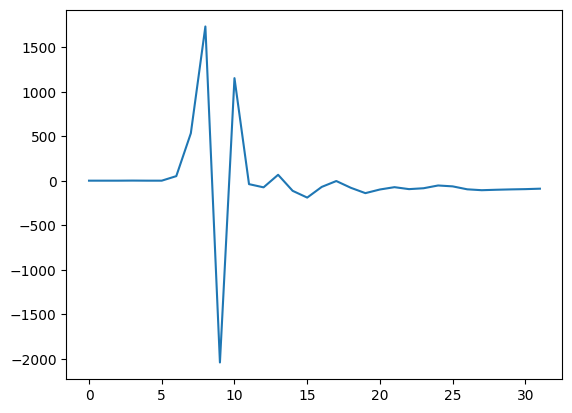

############ Finished procressing event 52 checked 911 waveforms with 1 problems
Check should be the same length 822 822
----- Found lack of match -0.6467176156850769
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1983.0 1983.0
Compare time offline online 2209.1685442307694 2214.34228515625


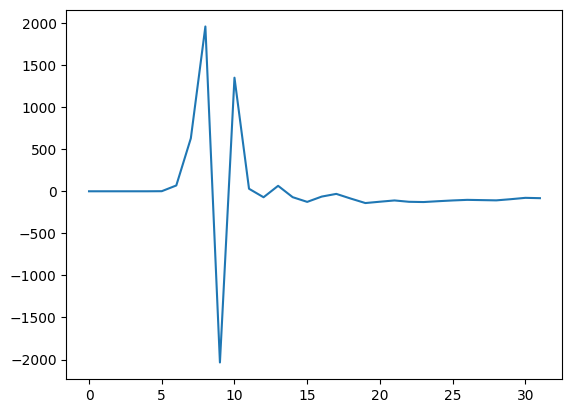

############ Finished procressing event 53 checked 822 waveforms with 1 problems
Check should be the same length 920 920
----- Found lack of match -2.642025348953041
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2636.0 2636.0
Compare time offline online 2209.463772794313 2230.5999755859375


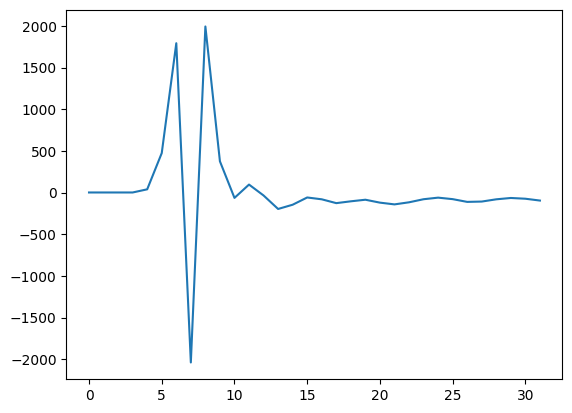

############ Finished procressing event 54 checked 920 waveforms with 1 problems
Check should be the same length 1114 1114
----- Found lack of match -2.624064935089052
hit local index  8
Compare card offline online 36 36
Compare chan offline online 5 5
Compare charge offline online 946.0 946.0
Compare time offline online 2065.69559087085 2086.6881103515625


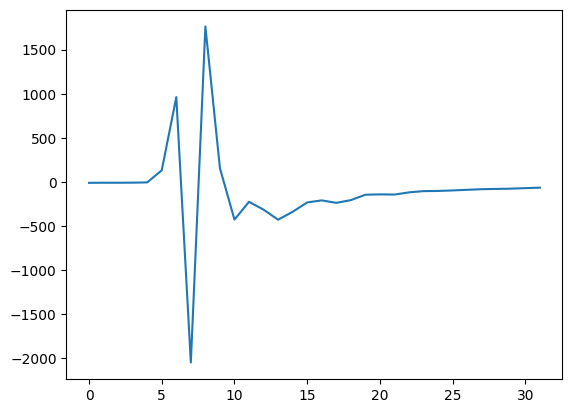

----- Found lack of match -0.6384805314631308
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1716.0 1716.0
Compare time offline online 2209.326237779545 2214.43408203125


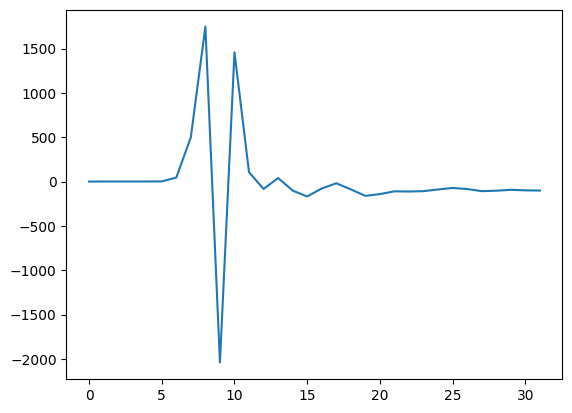

############ Finished procressing event 55 checked 1111 waveforms with 2 problems
Check should be the same length 896 896
----- Found lack of match -0.6319654373259027
hit local index  8
Compare card offline online 74 74
Compare chan offline online 1 1
Compare charge offline online 1077.0 1077.0
Compare time offline online 1577.6741348998303 1582.7298583984375


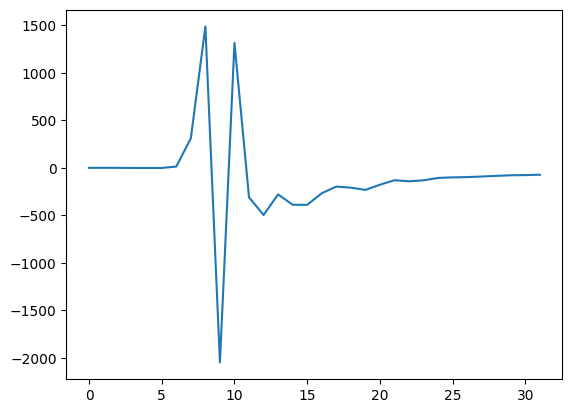

----- Found lack of match -0.6581014384846071
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1869.0 1869.0
Compare time offline online 2209.0719804843106 2214.3367919921875


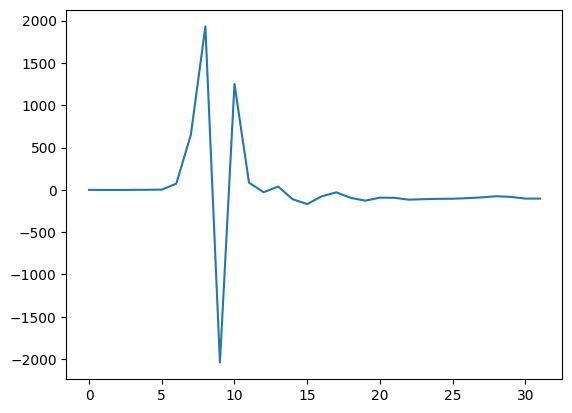

############ Finished procressing event 56 checked 891 waveforms with 2 problems
Check should be the same length 787 787
----- Found lack of match -6.803003583984378
hit local index  8
Compare card offline online 132 132
Compare chan offline online 3 3
Compare charge offline online 97.0 97.0
Compare time offline online 2197.54936 2251.973388671875


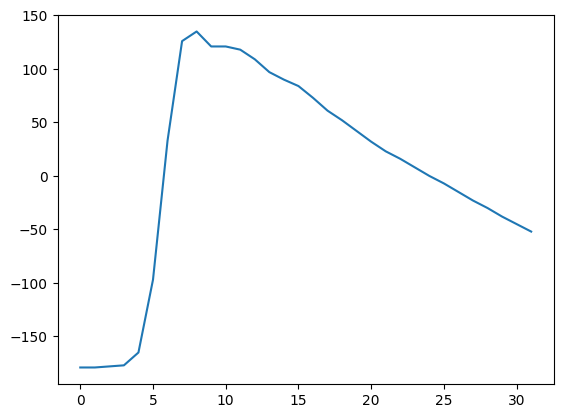

----- Found lack of match -7.27328666666665
hit local index  8
Compare card offline online 132 132
Compare chan offline online 12 12
Compare charge offline online 129.0 129.0
Compare time offline online 5141.813706666667 5200.0


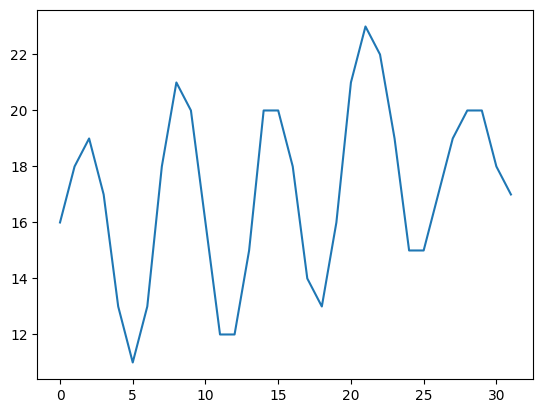

----- Found lack of match -7.319710512820507
hit local index  8
Compare card offline online 132 132
Compare chan offline online 12 12
Compare charge offline online 142.0 142.0
Compare time offline online 6109.442315897436 6168.0


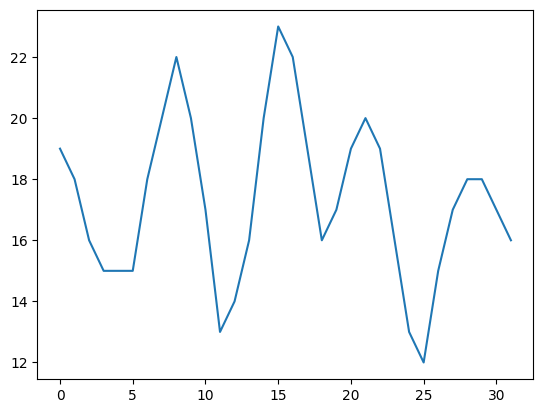

----- Found lack of match -7.28998096774194
hit local index  8
Compare card offline online 132 132
Compare chan offline online 12 12
Compare charge offline online 120.0 120.0
Compare time offline online 6813.6801522580645 6872.0


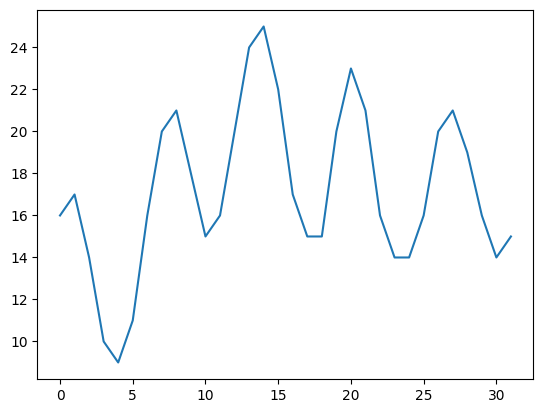

----- Found lack of match -2.6218188260594104
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2149.0 2149.0
Compare time offline online 1201.6024757587122 1222.5770263671875


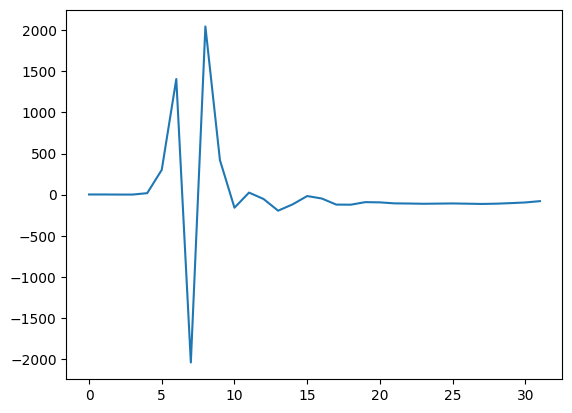

----- Found lack of match -3.674289079909954
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 971.0 971.0
Compare time offline online 1233.2957508372829 1262.6900634765625


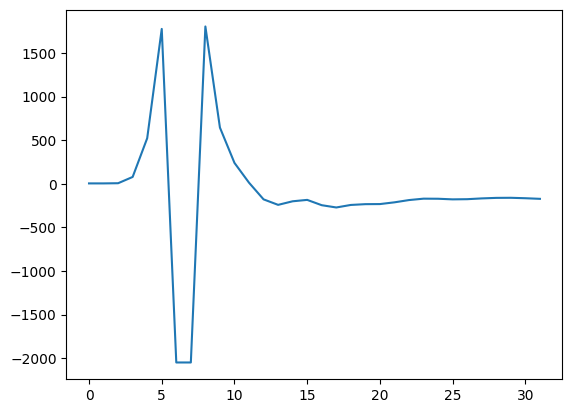

----- Found lack of match -2.6240175708882134
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2357.0 2357.0
Compare time offline online 2209.6052715422693 2230.597412109375


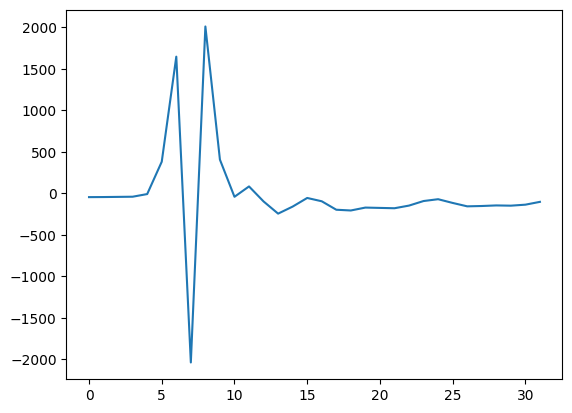

############ Finished procressing event 57 checked 784 waveforms with 7 problems
Check should be the same length 541 541
############ Finished procressing event 58 checked 539 waveforms with 0 problems
Check should be the same length 352 352
----- Found lack of match -0.6433960343657077
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1609.0 1609.0
Compare time offline online 2209.262865904762 2214.4100341796875


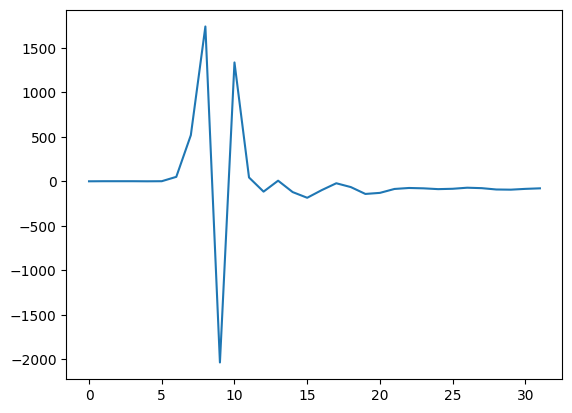

############ Finished procressing event 59 checked 351 waveforms with 1 problems
Check should be the same length 1433 1433
----- Found lack of match -2.668820179546742
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 2635.0 2635.0
Compare time offline online 6209.315576258939 6230.6661376953125


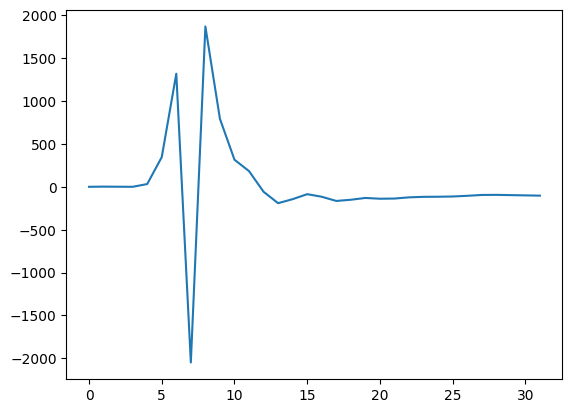

----- Found lack of match -3.6392353150566805
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 420.0 420.0
Compare time offline online 6209.461068651422 6238.574951171875


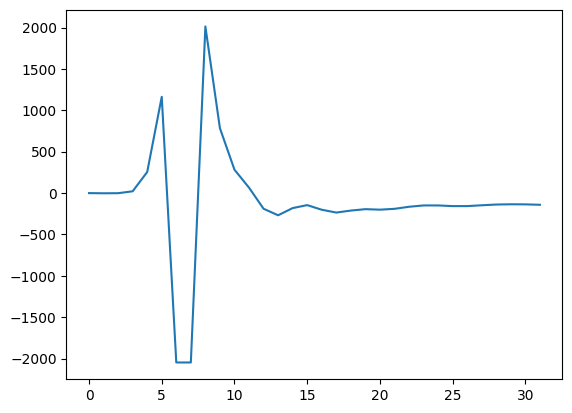

############ Finished procressing event 60 checked 1426 waveforms with 2 problems
Check should be the same length 1063 1063
----- Found lack of match -3.959723228076598
hit local index  8
Compare card offline online 131 131
Compare chan offline online 12 12
Compare charge offline online 113.0 113.0
Compare time offline online 2515.7652073394497 2547.4429931640625


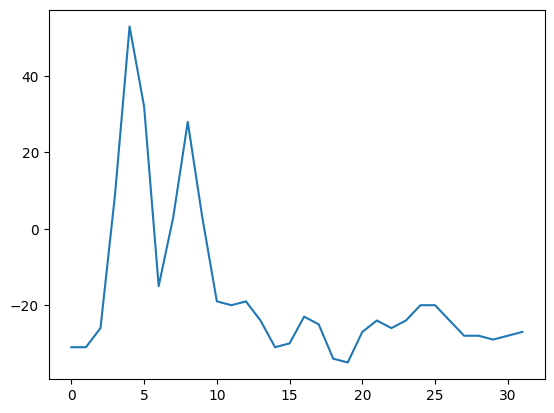

----- Found lack of match -0.6273743916160015
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1683.0 1683.0
Compare time offline online 2209.267137679572 2214.2861328125


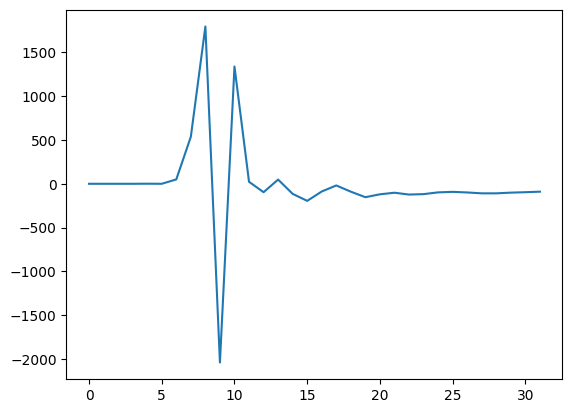

############ Finished procressing event 61 checked 1060 waveforms with 2 problems
Check should be the same length 927 927
############ Finished procressing event 62 checked 915 waveforms with 0 problems
Check should be the same length 352 352
----- Found lack of match -0.8156862701579826
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 2238.0 2238.0
Compare time offline online 2240.4106670652986 2246.9361572265625


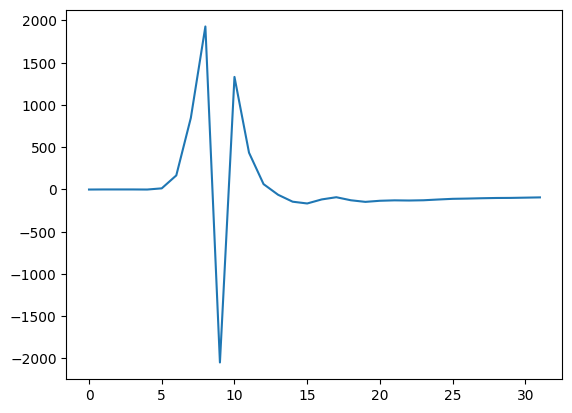

############ Finished procressing event 63 checked 352 waveforms with 1 problems
Check should be the same length 1898 1898
----- Found lack of match -0.6702675251423784
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1180.0 1180.0
Compare time offline online 2209.044842220736 2214.406982421875


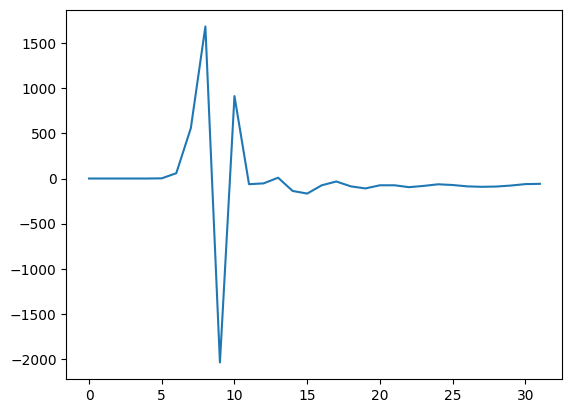

----- Found lack of match -2.644220479823389
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1353.0 1353.0
Compare time offline online 4529.511885575475 4550.6656494140625


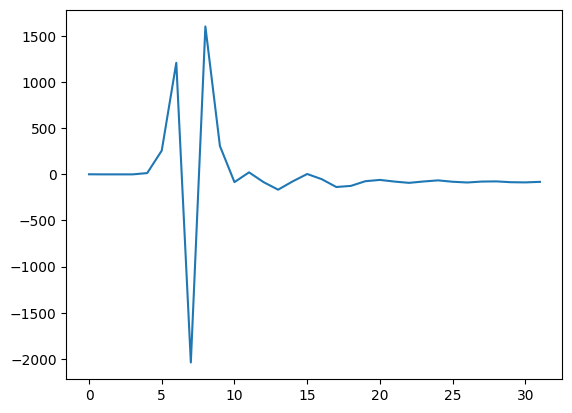

----- Found lack of match -0.8605729073290149
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 2150.0 2150.0
Compare time offline online 4568.20831224918 4575.0928955078125


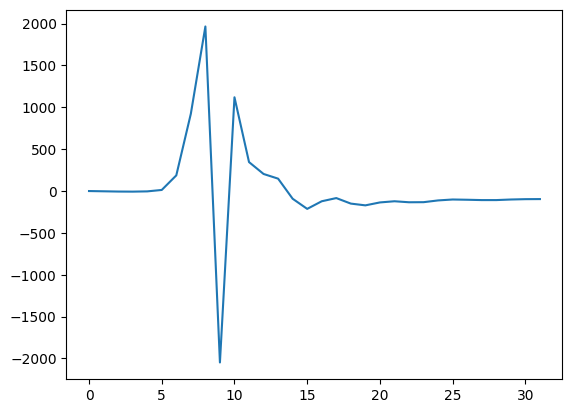

----- Found lack of match -4.298160416910264
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 291.0 291.0
Compare time offline online 5063.31405748503 5097.6993408203125


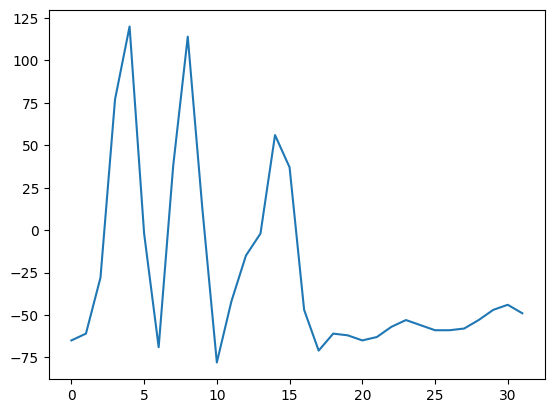

############ Finished procressing event 64 checked 1895 waveforms with 4 problems
Check should be the same length 434 434
----- Found lack of match -0.6180007045234106
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2508.0 2508.0
Compare time offline online 2209.3254035435 2214.2694091796875


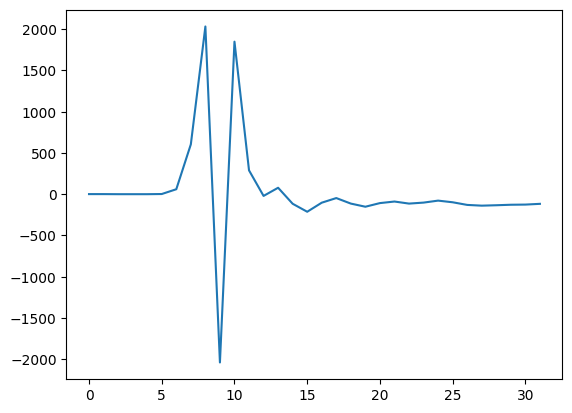

############ Finished procressing event 65 checked 434 waveforms with 1 problems
Check should be the same length 1240 1240
----- Found lack of match -7.275200000000041
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 186.0 186.0
Compare time offline online 5341.7984 5400.0


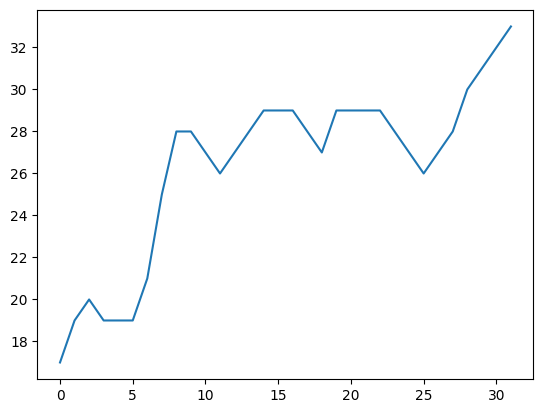

No hit match for waveform at  7944.0
----- Found lack of match -2.634139491564781
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 2642.0 2642.0
Compare time offline online 2209.5018352393568 2230.574951171875


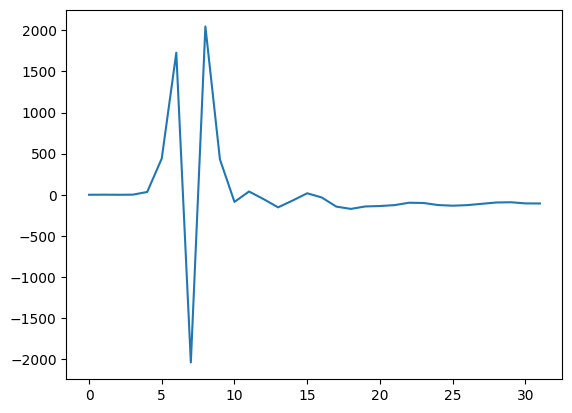

############ Finished procressing event 66 checked 1235 waveforms with 2 problems
Check should be the same length 806 806
----- Found lack of match -2.5644269490244938
hit local index  8
Compare card offline online 42 42
Compare chan offline online 5 5
Compare charge offline online 1124.0 1124.0
Compare time offline online 3289.769252376554 3310.28466796875


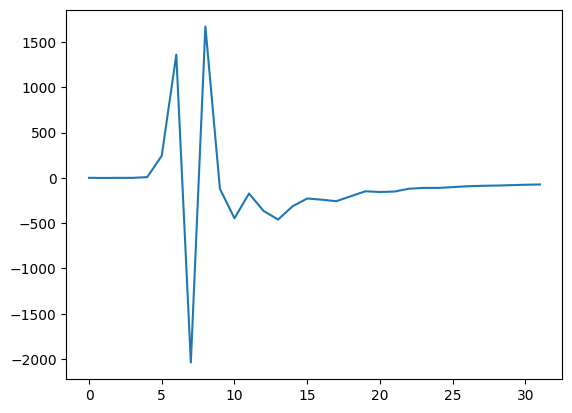

No hit match for waveform at  7952.0
############ Finished procressing event 67 checked 801 waveforms with 1 problems
Check should be the same length 66 66
############ Finished procressing event 68 checked 66 waveforms with 0 problems
Check should be the same length 43 43
No hit match for waveform at  7984.0
No hit match for waveform at  7984.0
No hit match for waveform at  7984.0
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
No hit match for waveform at  7992.0
----- Found lack of match -0.6687001976711144
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1211.0 1211.0
Compare time offline online 2209.0887529108186 2214.4383544921875


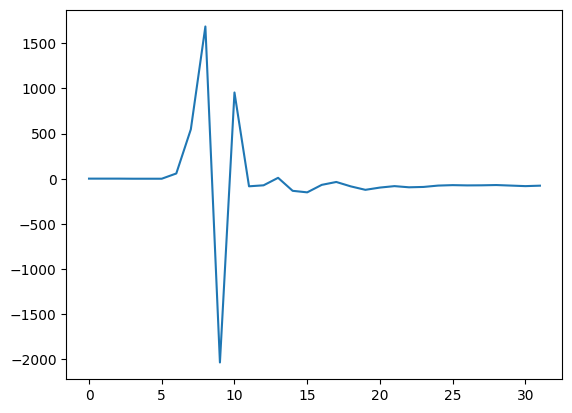

############ Finished procressing event 69 checked 38 waveforms with 1 problems
Check should be the same length 873 873
############ Finished procressing event 70 checked 873 waveforms with 0 problems
Check should be the same length 794 794
----- Found lack of match -0.5970272981752487
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1844.0 1844.0
Compare time offline online 2209.4375267317855 2214.2137451171875


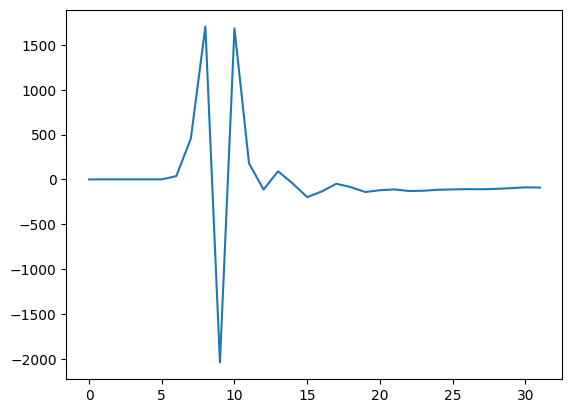

----- Found lack of match -3.6011065346525015
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 341.0 341.0
Compare time offline online 2241.36937037903 2270.17822265625


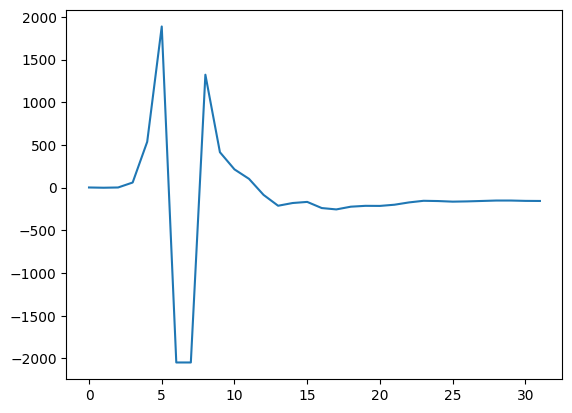

############ Finished procressing event 71 checked 793 waveforms with 2 problems
Check should be the same length 893 893
############ Finished procressing event 72 checked 893 waveforms with 0 problems
Check should be the same length 354 354
############ Finished procressing event 73 checked 354 waveforms with 0 problems
Check should be the same length 922 922
----- Found lack of match -0.6816288445016312
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1268.0 1268.0
Compare time offline online 2209.214449712737 2214.66748046875


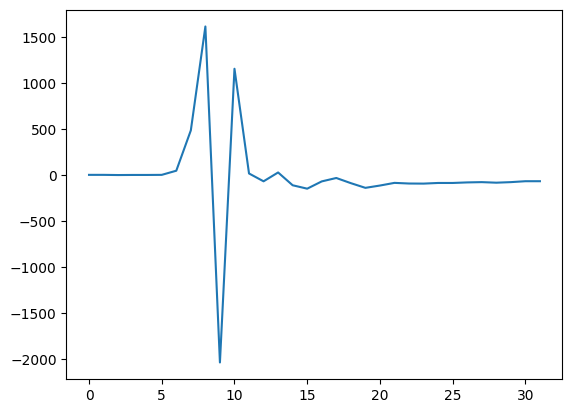

############ Finished procressing event 74 checked 921 waveforms with 1 problems
Check should be the same length 1044 1044
############ Finished procressing event 75 checked 1042 waveforms with 0 problems
Check should be the same length 483 483
----- Found lack of match -4.214662662847729
hit local index  8
Compare card offline online 131 131
Compare chan offline online 12 12
Compare charge offline online 123.0 123.0
Compare time offline online 2511.9239340487807 2545.6412353515625


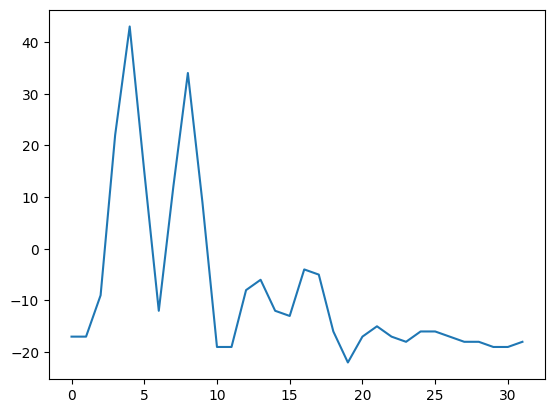

----- Found lack of match -0.6162771589199565
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 2369.0 2369.0
Compare time offline online 2209.345295423953 2214.2755126953125


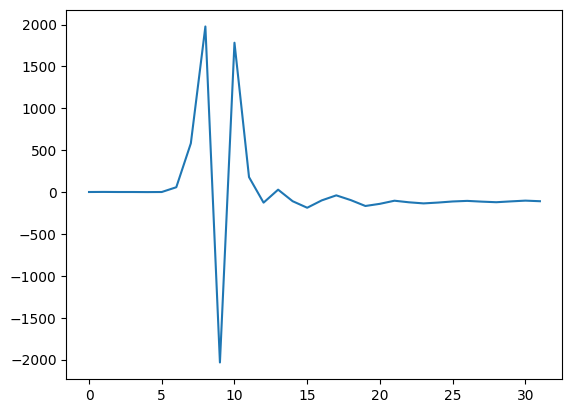

----- Found lack of match -0.6764378112313238
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1222.0 1222.0
Compare time offline online 2209.254146924212 2214.6656494140625


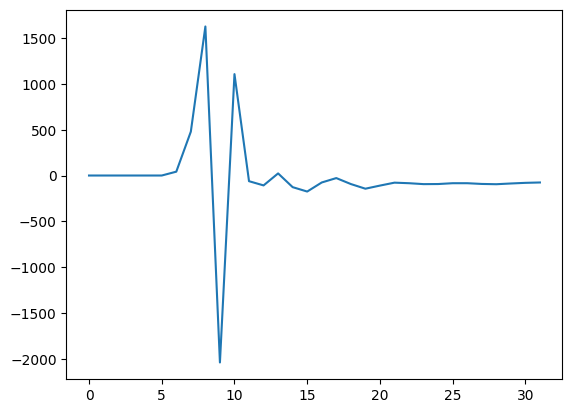

############ Finished procressing event 76 checked 482 waveforms with 3 problems
Check should be the same length 797 797
----- Found lack of match -2.643927044152747
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1133.0 1133.0
Compare time offline online 2209.445995756153 2230.597412109375


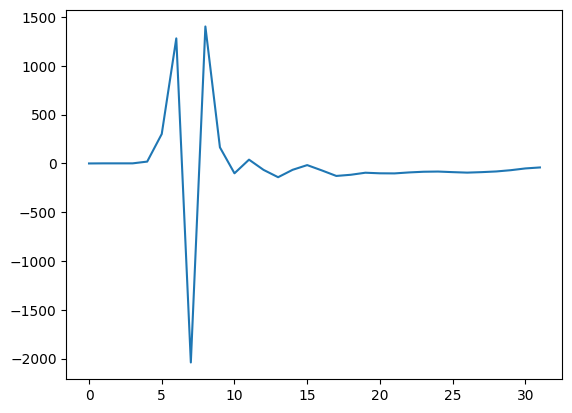

############ Finished procressing event 77 checked 797 waveforms with 1 problems
Check should be the same length 162 162
----- Found lack of match -0.594189781616592
hit local index  8
Compare card offline online 107 107
Compare chan offline online 13 13
Compare charge offline online 1120.0 1120.0
Compare time offline online 4769.454001278317 4774.20751953125


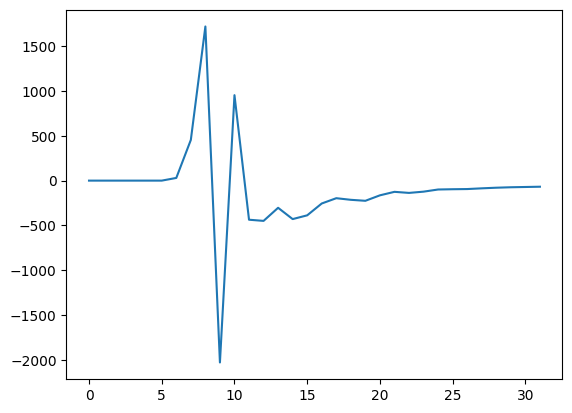

############ Finished procressing event 78 checked 162 waveforms with 1 problems
Check should be the same length 331 331
############ Finished procressing event 79 checked 329 waveforms with 0 problems
Check should be the same length 887 887
----- Found lack of match -2.632074410253608
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1503.0 1503.0
Compare time offline online 2209.543258233596 2230.599853515625


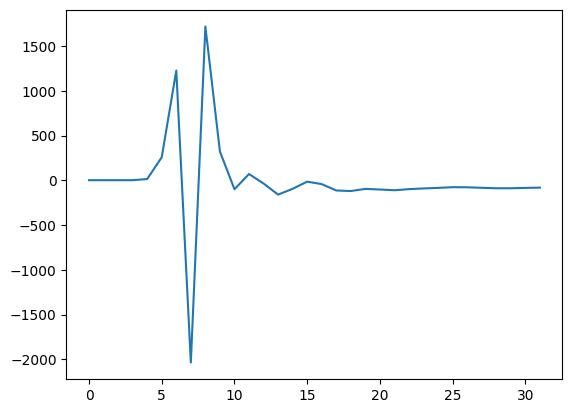

############ Finished procressing event 80 checked 887 waveforms with 1 problems
Check should be the same length 194 194
############ Finished procressing event 81 checked 194 waveforms with 0 problems
Check should be the same length 710 710
----- Found lack of match -0.6524959536534425
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 996.0 996.0
Compare time offline online 2209.354373191085 2214.5743408203125


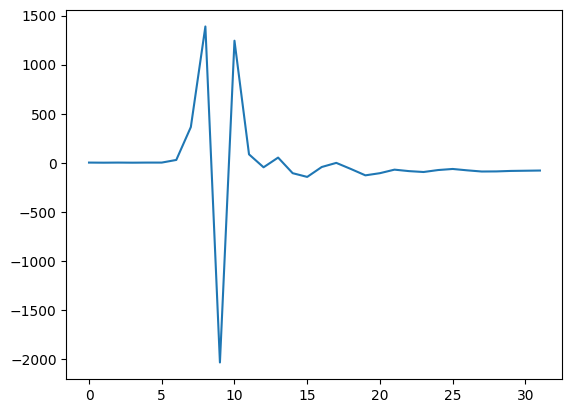

----- Found lack of match -2.682502306247727
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 2417.0 2417.0
Compare time offline online 2240.848575300018 2262.30859375


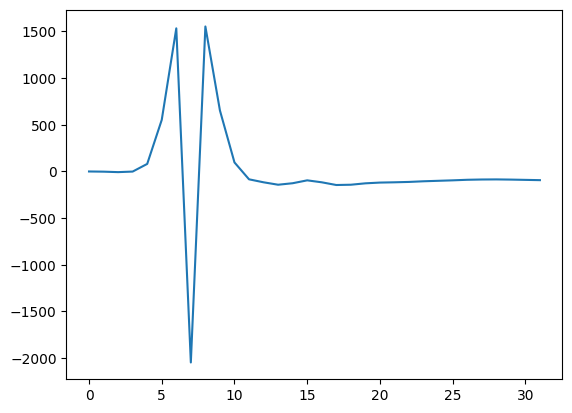

############ Finished procressing event 82 checked 710 waveforms with 2 problems
Check should be the same length 971 971
############ Finished procressing event 83 checked 971 waveforms with 0 problems
Check should be the same length 644 644
############ Finished procressing event 84 checked 641 waveforms with 0 problems
Check should be the same length 798 798
----- Found lack of match -7.290958484848488
hit local index  8
Compare card offline online 132 132
Compare chan offline online 4 4
Compare charge offline online 147.0 147.0
Compare time offline online 7093.672332121212 7152.0


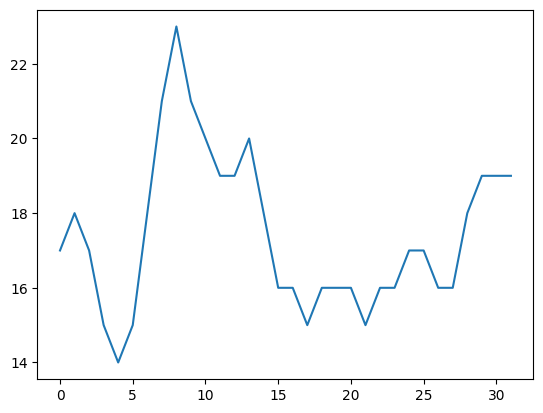

----- Found lack of match -2.690700288413325
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 3666.0 3666.0
Compare time offline online 3881.1418781614434 3902.66748046875


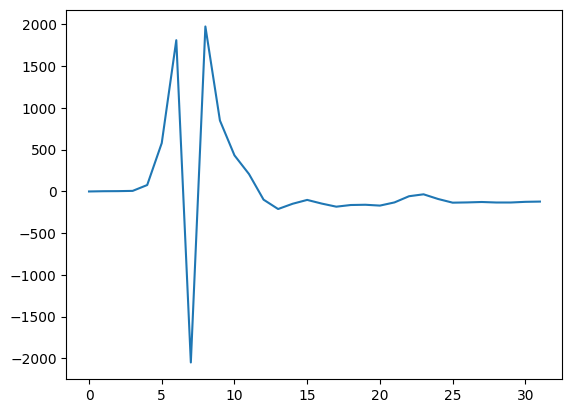

----- Found lack of match -6.947743752266433
hit local index  8
Compare card offline online 130 130
Compare chan offline online 6 6
Compare charge offline online 2138.0 2138.0
Compare time offline online 4021.4268390443685 4077.0087890625


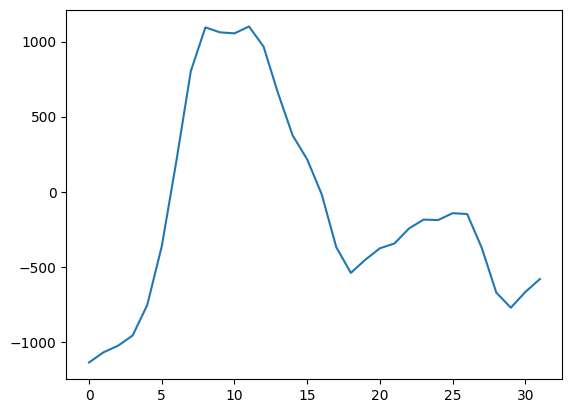

############ Finished procressing event 85 checked 791 waveforms with 3 problems
Check should be the same length 1399 1399
No hit match for waveform at  7944.0
No hit match for waveform at  7960.0
----- Found lack of match -2.6306421649507854
hit local index  8
Compare card offline online 48 48
Compare chan offline online 7 7
Compare charge offline online 897.0 897.0
Compare time offline online 937.6444378757062 958.6895751953125


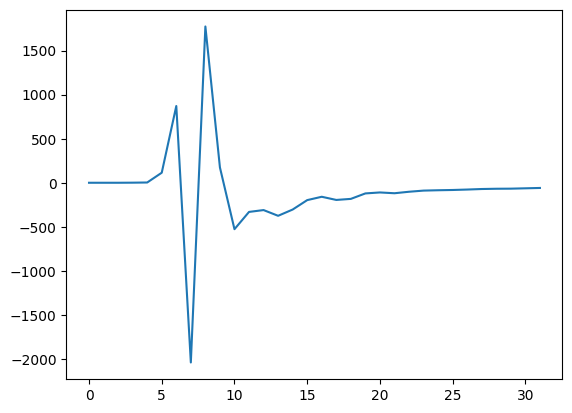

----- Found lack of match -2.6288860049390337
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1175.0 1175.0
Compare time offline online 2201.5443514136127 2222.575439453125


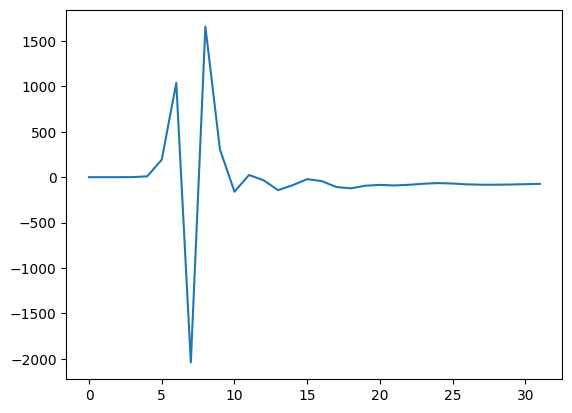

----- Found lack of match -2.7360079229962935
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 3098.0 3098.0
Compare time offline online 2240.7103252879047 2262.598388671875


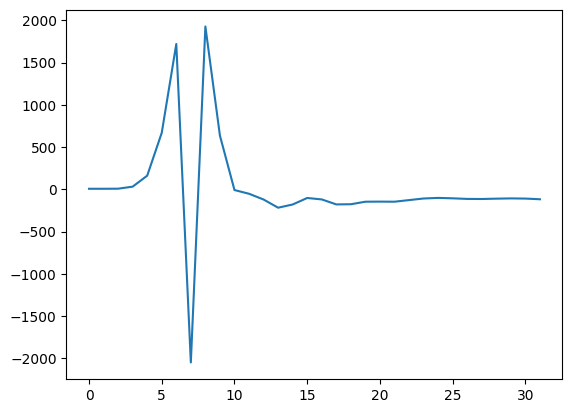

############ Finished procressing event 86 checked 1399 waveforms with 3 problems
Check should be the same length 286 286
############ Finished procressing event 87 checked 286 waveforms with 0 problems
Check should be the same length 640 640
----- Found lack of match -2.6442352160368046
hit local index  8
Compare card offline online 130 130
Compare chan offline online 13 13
Compare charge offline online 1112.0 1112.0
Compare time offline online 2209.4435303810806 2230.597412109375


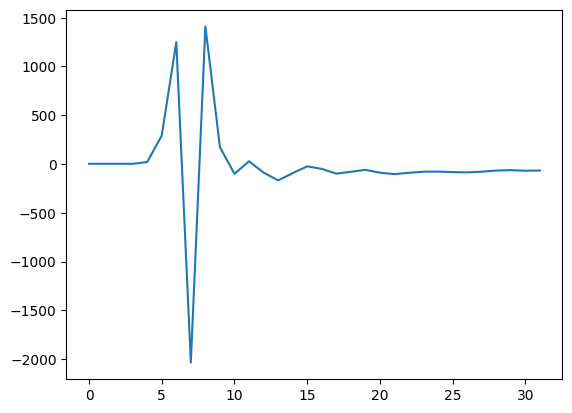

----- Found lack of match -2.6477388766371064
hit local index  8
Compare card offline online 130 130
Compare chan offline online 15 15
Compare charge offline online 1040.0 1040.0
Compare time offline online 2209.4842266822156 2230.6661376953125


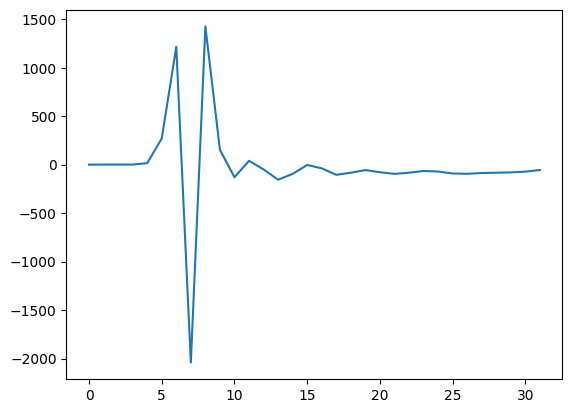

############ Finished procressing event 88 checked 640 waveforms with 2 problems
Check should be the same length 877 877
No hit match for waveform at  7992.0
############ Finished procressing event 89 checked 877 waveforms with 0 problems
Check should be the same length 868 868
----- Found lack of match -2.694946667168381
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 3089.0 3089.0
Compare time offline online 2240.6483124048405 2262.2078857421875


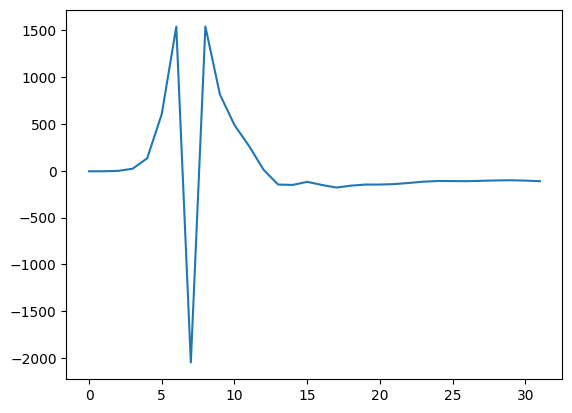

############ Finished procressing event 90 checked 868 waveforms with 1 problems
Check should be the same length 1042 1042
----- Found lack of match -2.6658116264009095
hit local index  8
Compare card offline online 131 131
Compare chan offline online 13 13
Compare charge offline online 2355.0 2355.0
Compare time offline online 2201.3595421450427 2222.68603515625


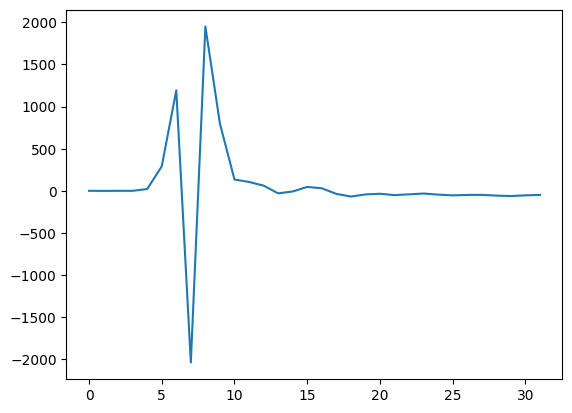

############ Finished procressing event 91 checked 1042 waveforms with 1 problems
Check should be the same length 1477 1477
No hit match for waveform at  7992.0
No hit match for waveform at  7984.0
No hit match for waveform at  7944.0
############ Finished procressing event 92 checked 1473 waveforms with 0 problems
Check should be the same length 910 910
############ Finished procressing event 93 checked 909 waveforms with 0 problems
Check should be the same length 324 324
############ Finished procressing event 94 checked 324 waveforms with 0 problems
Check should be the same length 891 891
----- Found lack of match -2.6158332812526623
hit local index  8
Compare card offline online 12 12
Compare chan offline online 15 15
Compare charge offline online 703.0 703.0
Compare time offline online 1273.6735534765412 1294.6002197265625


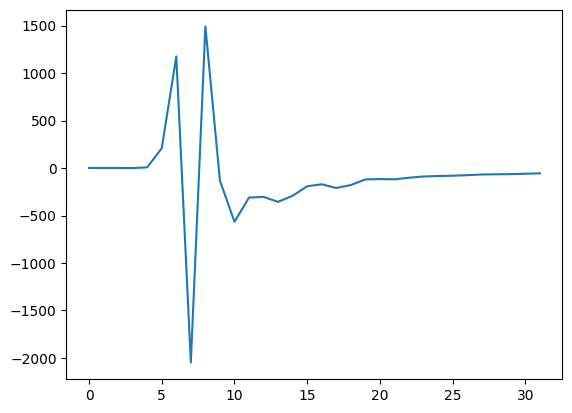

----- Found lack of match -4.167887251420439
hit local index  8
Compare card offline online 130 130
Compare chan offline online 14 14
Compare charge offline online 272.0 272.0
Compare time offline online 2494.7096363636365 2528.052734375


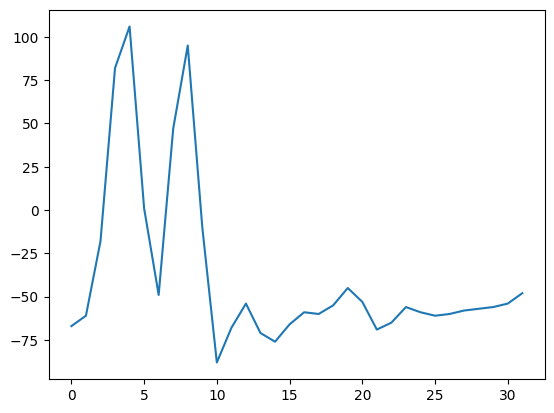

############ Finished procressing event 95 checked 890 waveforms with 2 problems
Check should be the same length 799 799
----- Found lack of match -4.62940741498403
hit local index  8
Compare card offline online 131 131
Compare chan offline online 15 15
Compare charge offline online 84.0 84.0
Compare time offline online 2496.7661322816903 2533.8013916015625


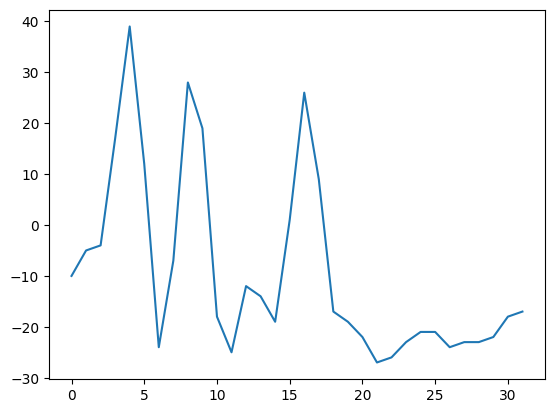

############ Finished procressing event 96 checked 798 waveforms with 1 problems
Check should be the same length 923 923
No hit match for waveform at  7960.0
----- Found lack of match -0.6697948113098278
hit local index  8
Compare card offline online 130 130
Compare chan offline online 9 9
Compare charge offline online 1959.0 1959.0
Compare time offline online 2240.689615142334 2246.0479736328125


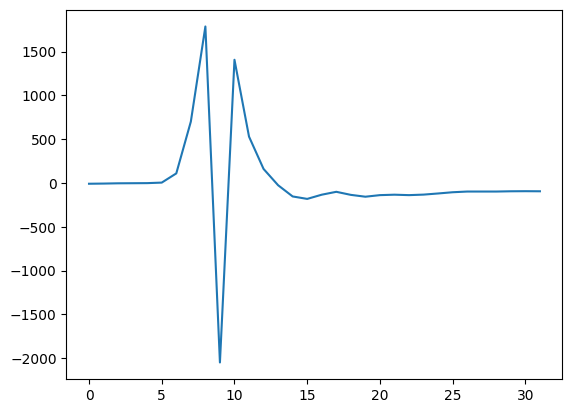

############ Finished procressing event 97 checked 922 waveforms with 1 problems
Check should be the same length 330 330
############ Finished procressing event 98 checked 329 waveforms with 0 problems
Check should be the same length 810 810
No hit match for waveform at  7952.0
----- Found lack of match -3.716279170586006
hit local index  8
Compare card offline online 130 130
Compare chan offline online 7 7
Compare charge offline online 619.0 619.0
Compare time offline online 2240.9559238618745 2270.6861572265625


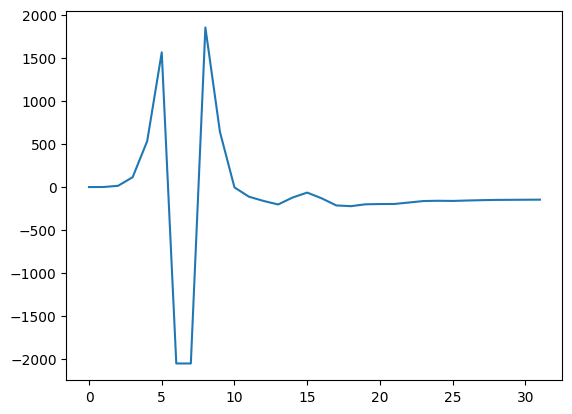

############ Finished procressing event 99 checked 810 waveforms with 1 problems


In [11]:
for iev, event in enumerate(all_events):
    
    online_hit_times  = event["hit_pmt_times"]
    online_hit_charges  = event["hit_pmt_charges"]
    online_hit_cards  = event["hit_mpmt_card_ids"]
    online_hit_chan   = event["hit_pmt_channel_ids"]

    wf_start   = event["pmt_waveform_times"]
    wf_waveforms    = event["pmt_waveforms"]
    wf_end     = wf_start + 8.0 * ak.num(wf_waveforms)
    wf_card    = event["pmt_waveform_mpmt_card_ids"]
    wf_chan    = event["pmt_waveform_pmt_channel_ids"]

    hit_match_index, wf_match_index  = match_hits_waveforms(event)
    print("Check should be the same length",len(wf_match_index),len(wf_waveforms))

    #select waveforms to process 
    wf_filter = ak.num(wf_waveforms)==32

    wf_process = wf_waveforms[wf_filter]
    wf_process_start = wf_start[wf_filter]
    wf_process_hit_index = wf_match_index[wf_filter]
    wf_process_card = wf_card[wf_filter]
    wf_process_chan = wf_chan[wf_filter]
    
    #outputs a list of hits and the wf_index of the hits hit_wf_index
    found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_local_indices = do_hit_processing(wf_process,wf_process_start,wf_process_card,wf_process_chan)

    problem_flag = 0
    for offline_charge, offline_time, offline_card, offline_chan, wf_index, hit_local_index in zip(found_hit_charge, found_hit_time, found_hit_card, found_hit_chan, hit_wf_index, hit_local_indices):
        
        hit_index = wf_process_hit_index[wf_index]
        if hit_index<0:
            print("No hit match for waveform at ", wf_process_start[wf_index])
            continue
        
        # if there is an issue with the timing or charges found
        if np.abs(offline_time-online_hit_times[hit_index])>0.001 or online_hit_charges[hit_index]!=offline_charge :
            problem_flag +=1
            print("----- Found lack of match",(offline_time-online_hit_times[hit_index])/8.0)
            print("hit local index ",hit_local_index)
            print("Compare card offline online",offline_card,online_hit_cards[hit_index])
            print("Compare chan offline online",offline_chan,online_hit_chan[hit_index])
            print("Compare charge offline online",offline_charge,online_hit_charges[hit_index])
            print("Compare time offline online",offline_time,online_hit_times[hit_index])
            fig = plt.figure()
            plt.plot(wf_process[wf_index])
            plt.show()
    
    print("############ Finished procressing event",iev,"checked",len(wf_process),"waveforms with",problem_flag,"problems")
    # input()

    


